# <font color='Green'> Example G-MODE KPFM Notebook </font>
## <font color='Green'>SPMonSPM August 2018 (Leuven, Belgium)</font>

### <font color='Black'>Author: Liam Collins</font>
### <font color='Black'>Oak Ridge National Laboratory</font>
#### <font color='Black'>Contributions to this notebook were made by Anugra Saxena, Raj Giridharagopal and Chris Smith</font>
#### <font color='Black'>Analysis is facilited through [Pycroscopy](https://github.com/pycroscopy/pycroscopy), an open source community driven data analysis platform for imaging and spectroscopic data sets. </font>



This notebook can be used to analyze G-KPFM data. The goal is to realize a time resolved KPFM measurement by recovery of the electrostatic foce directly from the photodetector response. Detailed Information on the data collection and background theory can be found in Collins et al. ([DOI: 10.1021/acsnano.7b02114](http://pubs.acs.org/doi/abs/10.1021/acsnano.7b02114))
<br>

## Load All Necessary Packages

First, we need to load the necessary packages.

In [9]:
# Import necessary libraries:

# Ensure that this code works on both python 2 and python 3
from __future__ import division, print_function, absolute_import, unicode_literals

# Visualization:
import matplotlib.pyplot as plt
from IPython.display import display, HTML
from scipy.signal import butter, filtfilt,correlate
from scipy.io import loadmat
from mpl_toolkits.axes_grid1 import make_axes_locatable
import matplotlib.cm as cm

# for downloading files:
import wget
import os

# General utilities:
import sys
from warnings import warn
import h5py
from functools import partial

# multivariate analysis:
from sklearn.cluster import KMeans
from sklearn.decomposition import NMF, FastICA
import subprocess

# Computation:
import numpy as np
import numpy.polynomial.polynomial as npPoly
from scipy.optimize import curve_fit

#sys.path.append('/home/challtdow/workspace/pyUSID')
#sys.path.append('/home/challtdow/workspace/pycroscopy')
def install(package):
    subprocess.call([sys.executable, "-m", "pip", "install", package])
    
try:
    import pyUSID as usid
except ImportError:
    print('pyUSID not found.  Will install with pip.')
    import pip
    install('pyUSID')
    import pyUSID as usid

try:
    import pycroscopy as px
except ImportError:
    print('pycroscopy not found.  Will install with pip.')
    import pip
    install('pycroscopy')
    import pycroscopy as px

    
#from usid.plot_utils import set_tick_font_size, plot_curves, plot_map_stack

In [10]:
# set up notebook to show plots within the notebook
% matplotlib inline
% precision %.4g

'%.4g'

### <font color=green>  Materials and Methods </font>


#### <font color=green>  Material </font>
Sample is courtesy of Wanyi Nie - Los Alamos National Lab. It consists of a organometallic perovskite of the form APbI3 where A is consists of a mixture of MA stabilized with small amounts of Cs- (MA:Cs=95:5). Samples  have millimeter-scale grains made possible using a hot-casting method.[1] Sample is deposited on interdigated electrodes (Au on Silicon Oxide) which can be independently biased to induce field driven ion dynamics in the perovskite layer.<br>

[1] Nie, Wanyi, et al. "High-efficiency solution-processed perovskite solar cells with millimeter-scale grains." Science 347.6221 (2015): 522-525.

#### <font color=green>  Quick Description of the measurement </font>
This G-KPFM measurement was capured using a MFP3D AFM from Asylum instruments using a Pt/Ir coated cantilever DPE18 from budget sensors. The nominal resonance frqeuency and spring constant of the cantilever are 65 KHz and ~2.8 N/m respectively. G-KPFM data is captured during the lift portion (100 nm) of the scan captured using a scan rate of 0.48 Hz. The G-KPFM excitation and data acquistion is performed using a LabView/Matlab controller implemented in PXI architecture using National Instruments NI-6124 fast AWG and DAQ cards. In this particular measurement data was captured at a 2 MHz data aquisition rate. The data aquired was the raw, unfiltered, photodetector response. Triggers from the AFM, at the beggining of the nap retrace scan, were used to initate the G-KPFM measurement. The tip excitation was an AC voltage centred a the resonance frequency and having an AC amplitude of 2Vp-p. A syncrconized square pulse wave was applied to the source electrode to initate the field driven charge distribution within the film. In principle a variety of sample excitation waveforms can be used. In this example our sample excitation gives a "charging" and "discharging" event at each spatial location of the sample.


The resulting data cube is 64 x 128 in spatial dimensions, and includes 16,348 points in the spectral (time) domain. In the following notebook I will demonstrate how it is possible to convert this noisey photodetector signal into a fast time resolved measurement of surface potential measurement.


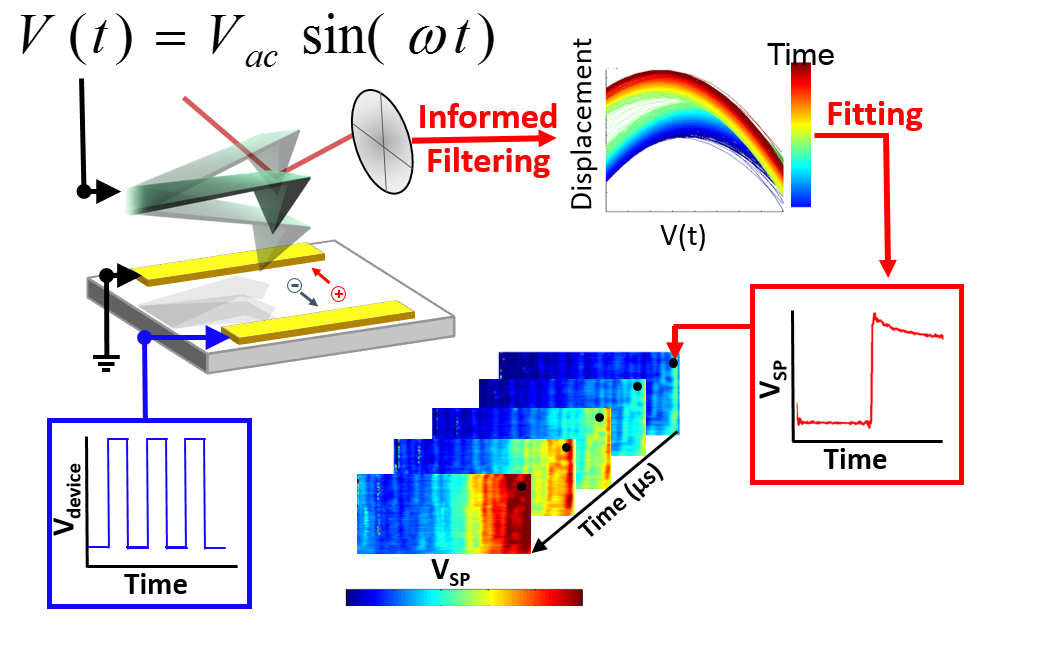

In [11]:
from IPython.display import Image
path = os.getcwd()
fig1 = path + '/Figures/Figure 1 GKPFM.png'
Image(filename=fig1)

## <font color=green>  Scientific Workflow </font>
**You can change options below depending on what analysis you want to perform** <br>
<br>
**Note: The data provided has already been converted to H5 format (from .dat) and analyzed. The filtered data, CPD, SVD results etc. are all stored in this hierarchial format so you dont need to re-run the analysis (unless you want to). HOWEVER, the raw data is also within the H5 file so if you find a mistake, want to play with filtering, or find a better way to analyze the data then you can do so without having to re-run the experiment. This is a big advantage of this type of information centric workflow.**

**The work flow is comprised as follows:**<br>

(1a) Translation of G-Tune data to H5  (I have done this for you) <br>
(1b) Fitting Tune data to Simple Harmonic Oscillator model<br>

(2a) Translation of Image data to H5 (I have done this for you)<br>
(2b) Denoising by Fourier Filtering(optional)<br>
(2b) Denoising by Singular Value Decomposition (SVD) (optional)<br>

(3a) Fast Free Force Recovery Procedure<br>
(3b) Fitting to extract CPD and C'<br>

(4a)Demonstration of tools for Spectral Unmixing and Clustering<br></font>

In [12]:
##################################################################
##Output file determines where images are saved to
##Create the directory if it doesn't exist
################################################################

current_path = os.getcwd()
output_filepath = os.path.join(current_path, "ImageData") 
if not os.path.exists(output_filepath):
    os.mkdir(output_filepath)

################################################################
###Here you can decide what analysis to perform
################################################################

save_figure = True # Print plots as .tif figures

Filter_data= True   # Set this to true if you want to Fourier filter data

DO_F3R = False   # Set this to true if you want to do F3R recovery or just load data from file

do_SVD_denoise= True   # Set this to true if you want to PCA denoise your data

do_para_fit= False # Set this to true if you want to do parabolic fitting

do_SVD_CPD= True   # Set this to true if you want to do PCA of CPD results

do_Kmeans=True # Set this to true if you want to do Kmeans CPD results

##################################################################
## Number of cores available for parallel processing
################################################################

num_cores=2

#These are the dimensions of you image data in microns
img_length = 80e-6
img_height = 40e-6



##  <font color=green> Step 1) Describe Cantilever Transfer Function <font/>

Encoded in the photodetector singal is the cantilever dynamics in response to the electrostatic force between tip-sample (as well as noise (1/f noise, thermal, instrument etc.)). 

Our goal is to separate the inherent cantilever dynamics from the electrostatic force. For this we need to describe our cantilever in terms of its frequency dependent cantilever transfer function. This can be done by first measuring the resonant properties of the cantilever (SHO parameters) and subsequently contructing an effective transfer function from the fit. Once we have the frequency dependent transfer function we can deconvolute it from the spectral data collected during the G-KPFM measurements.

To determine the SHO properties I calibrate the frequency response of the cantilever at the beginning (and/or end) of measurement. This can be done using the thermal noise method, or an electrostatic tune far from the cantilever surface (>> 100nm). I usually do both. Its important that the transfer function describes the cantilever behaviour in the **absence** of tip-sample interaction force.

####  <font color=green> Step 1a. Go fetch the data <font/>
The tune and image data are stored on the IFIM website. The following cell will go download the data. In total there is ~4 Gb of data...so it might take some time to download depending on the strenght of your internet connection. <br>



In [13]:
tune_file_path = wget.download('https://ifim.ornl.gov/data/GFA0_tune_0012.h5')
    
h5_tune_file = h5py.File(tune_file_path, 'r+')
usid.hdf_utils.print_tree(h5_tune_file)


100% [..................................................] 117545440 / 117545440/
├ Measurement_000
  ---------------
  ├ Channel_000
    -----------
    ├ Raw_Data
  ├ Channel_001
    -----------
    ├ Raw_Data
  ├ Position_Indices
  ├ Position_Values
  ├ Spectroscopic_Indices
  ├ Spectroscopic_Values
  ├ Tune_Function_000
    -----------------
    ├ Position_Indices
    ├ Position_Values
    ├ Spectroscopic_Indices
    ├ Spectroscopic_Values
    ├ Tune_Data


Notice the "tree" showing what is inside the H5 file we downloaded. There are 2 channels, channel 00 (PD response), channel 01 is the tip voltage. The rest are ancillary datasets. Any filtering, clustering or analysis performed on the data will be saved as an additional level in this hierachial data structure. Notice even though we will begin to process the raw data...we always retain a permanent record of the raw data.

#### <font color=green> Step 1b. Extract the Resonance Modes and Fit to a simple harmonic oscillator model <font/>

C:\Users\lz1\AppData\Local\Continuum\Anaconda3\lib\site-packages\ipykernel\__main__.py:53: RuntimeWarning: divide by zero encountered in true_divide


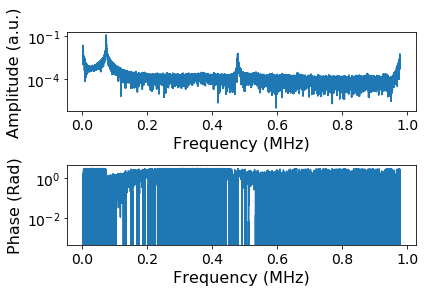

In [14]:
# In future I should put this and the following cell into a process class 

##############################################################
##Step 1b. Extract the Resonance Modes Considered in the Force Reconstruction
##############################################################

#define number of eigenmodes to consider
num_bandsVal=2

#define bands (center frequency +/- bandwith)
w_center1 = 70E3
bandwidth1 = 10E3
w_center2 = 480E3
bandwidth2 = 20E3

MB0_w1 = w_center1 - bandwidth1
MB0_w2 = w_center1 + bandwidth1
MB1_w1 = w_center2 - bandwidth2
MB1_w2 = w_center2 + bandwidth2

MB1_amp = 30E-9
MB2_amp = 1E-9

MB_parm_vec = np.array([MB1_amp,MB0_w1,MB0_w2,MB1_amp,MB1_w1,MB1_w2]).reshape(2,3)
band_edge_mat = MB_parm_vec[:,1:3]

h5_tune_resp = px.hdf_utils.find_dataset(h5_tune_file, 'Raw_Data')[0]
h5_tune = px.hdf_utils.find_dataset(h5_tune_file, 'Raw_Data')[-1]

# Fetch some important parameters
samp_rate = (px.hdf_utils.get_attr(h5_tune.parent.parent, 'IO_rate_[Hz]'))
num_rows=h5_tune.pos_dim_sizes[0]
N_points_per_line=h5_tune.spec_dim_sizes[0]
N_points_per_pixel=N_points_per_line / num_rows
w_vec2 = np.linspace(-0.5 * samp_rate, 0.5 * samp_rate - 1.0*samp_rate / N_points_per_line, N_points_per_line)
dt = 1/samp_rate
df = 1/dt

# Response
A_pd = np.mean(h5_tune_resp, axis=0)
yt0_tune = A_pd - np.mean(A_pd)
Yt0_tune = np.fft.fftshift(np.fft.fft(yt0_tune,N_points_per_line)*dt)

# Excitation
h5_spec_vals = px.hdf_utils.get_auxiliary_datasets(h5_tune, aux_dset_name='Spectroscopic_Values')[0]
BE_pd = h5_spec_vals[0, :]

f0 = BE_pd - np.mean(BE_pd)
F0 = np.fft.fftshift(np.fft.fft(f0,N_points_per_line)*dt)
excited_bin_ind = np.where(np.abs(F0)>0.5e-3)

# Divide response by drive to get transfer function
TF_vec = Yt0_tune/F0


# Plot response and fits
plt.figure(2)
plt.subplot(2,1,1)
plt.semilogy(np.abs(w_vec2[excited_bin_ind])*1E-6,np.abs(TF_vec[excited_bin_ind]))
plt.tick_params(labelsize=14)
plt.xlabel('Frequency (MHz)',fontsize=16)
plt.ylabel('Amplitude (a.u.)',fontsize=16)
plt.tight_layout(pad=1.0, w_pad=1.0, h_pad=1.0)
plt.subplot(2,1,2)
plt.semilogy(np.abs(w_vec2[excited_bin_ind])*1E-6,np.angle(TF_vec[excited_bin_ind]))
plt.tick_params(labelsize=14)
plt.xlabel('Frequency (MHz)',fontsize=16)
plt.ylabel('Phase (Rad)',fontsize=16)
plt.tight_layout(pad=1.0, w_pad=1.0, h_pad=1.0)

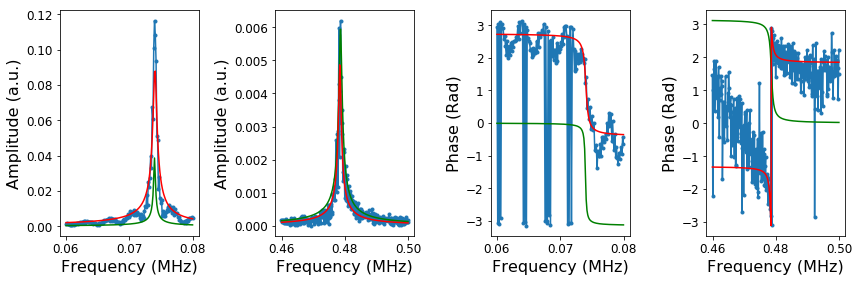

In [15]:
##############################################################
##Construct an effective Transfer function (TF_Norm) from SHO fits
##############################################################

TunePhase = -np.pi
num_bands = band_edge_mat.shape[0]
coef_mat = np.zeros((num_bands,4))
coef_guess_vec = np.zeros((4))
TF_fit_vec = np.zeros((w_vec2.shape))
TFb_vec = TF_vec[excited_bin_ind]
wb = w_vec2[excited_bin_ind]


for k1 in range(num_bandsVal):
    # locate the fitting region
    w1 = band_edge_mat[k1][0]
    w2 = band_edge_mat[k1][1]
    bin_ind1 = np.where(np.abs(w1-wb) == np.min(np.abs(w1-wb)))[0][0]
    bin_ind2 = np.where(np.abs(w2-wb) == np.min(np.abs(w2-wb)))[0][0]
    response_vec = TFb_vec[bin_ind1:bin_ind2+1].T
    wbb = wb[bin_ind1:bin_ind2+1].T/1E+6

    if k1 == 0:
        Q_guess = 300
    elif k1 == 1:
        Q_guess = 500
    else:
        Q_guess = 700

    response_mat = np.array([np.real(response_vec), np.imag(response_vec)]).T
    A_max_ind = np.argmax(np.abs(response_vec))
    A_max = response_vec[A_max_ind]
    A_guess = A_max/Q_guess
    wo_guess = wbb[A_max_ind]

    if k1 == 0:
        phi_guess = TunePhase

    coef_guess_vec = [np.real(A_guess), 
                      wo_guess, 
                      Q_guess, 
                      phi_guess]

    LL_vec = [0,w1/1E+6,1,np.pi] # lower limit
    UL_vec = [float("inf"),w2/1E+6,10000,-np.pi] # upper limit

    coef_vec = px.analysis.utils.be_sho.SHOestimateGuess(response_vec,wbb,10)

    response_guess_vec = px.analysis.utils.be_sho.SHOfunc(coef_guess_vec,wbb)
    response_fit_vec = px.analysis.utils.be_sho.SHOfunc(coef_vec,wbb)

    coef_vec[1] = coef_vec[1]*1E6
    coef_mat[k1,:] = coef_vec

    response_fit_full_vec = px.analysis.utils.be_sho.SHOfunc(coef_vec,w_vec2)

    TF_fit_vec = TF_fit_vec + response_fit_full_vec # check for length and dimension


    plt.figure(10, figsize=(12, 4))
    plt.subplot(1, 4, k1+1)
    plt.plot(wbb,np.abs(response_vec),'.-')
    plt.plot(wbb,np.abs(response_guess_vec),c='g')
    plt.plot(wbb,np.abs(response_fit_vec),c='r')
    plt.tick_params(labelsize=12)
    plt.xlabel('Frequency (MHz)', fontsize=16)
    plt.ylabel('Amplitude (a.u.)', fontsize=16)
    plt.subplot(1, 4, (k1+1)+2)
    plt.plot(wbb,np.angle(response_vec),'.-')
    plt.plot(wbb,np.angle(response_guess_vec),c='g')
    plt.plot(wbb,np.angle(response_fit_vec),c='r')
    plt.tick_params(labelsize=12)
    plt.xlabel('Frequency (MHz)', fontsize=16)
    plt.ylabel('Phase (Rad)', fontsize=16)
    plt.tight_layout(pad=1.0, w_pad=1.0, h_pad=1.0)

if save_figure == True:
    plt.savefig(output_filepath+'\SHOFitting.tif', format='tiff', transparent=True)

##############################################################
##Step 1d. write and save data to HDF5
##############################################################

Q = coef_mat[0,2]
TF_norm = ((TF_fit_vec - np.min(np.abs(TF_fit_vec))) / 
           np.max(np.abs(TF_fit_vec)) - np.min(np.abs(TF_fit_vec)))*Q


tf_grp = px.hdf_utils.create_indexed_group(h5_tune.parent.parent, 'Tune_Function')
tf_pos_dim = px.hdf_utils.Dimension('Single Step', 'a.u.', 1)
tf_spec_dim = px.hdf_utils.Dimension('Frequency', 'MHz', w_vec2)
h5_tf = px.hdf_utils.write_main_dataset(tf_grp, TF_norm.reshape(1, -1), 'Tune_Data', 
                                        'Response', 'a.u.', 
                                        tf_pos_dim, tf_spec_dim)
h5_tune_file.flush()

h5_tune_file.close()


**Ok, so its not the nicest tune. I uploaded the wrong calibration curve. But regardless, you get the point. We can use the fits to contruct and effective transfer function shown below**

Note: The Transfer Function is complex having both real and imaginery components.


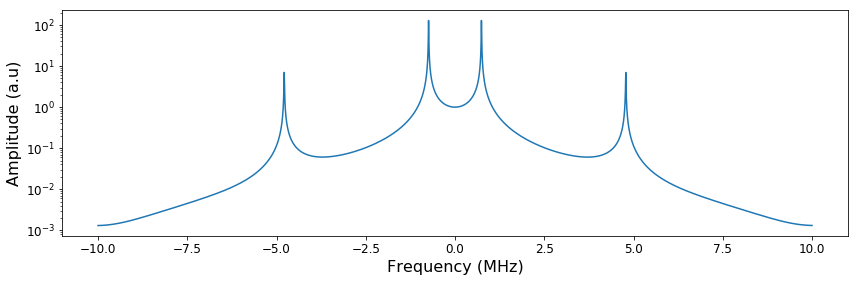

In [16]:

plt.figure(10, figsize=(12, 4))
plt.semilogy(w_vec2/100000,np.abs(TF_norm))
plt.tick_params(labelsize=12)
plt.xlabel('Frequency (MHz)', fontsize=16)
plt.ylabel('Amplitude (a.u)', fontsize=16)
plt.tight_layout(pad=1.0, w_pad=1.0, h_pad=1.0)

print("Note: The Transfer Function is complex having both real and imaginery components.")

# <font color=green> Step (2) Load, Translate and Denoize the G-KPFM data <font/>


#### Go Fetch the G-KPFM image data. Notice the first step would normally be to translate my data to H5...however, for simplicity and to limit the size of the download I have already translated and processed the data in H5 format.

In [20]:

input_file_path= wget.download('https://ifim.ornl.gov/data/GFA0_n1000mV_0003.h5')
parm_paths= wget.download('https://ifim.ornl.gov/data/GFA0_n1000mV_0003_all.mat')


#input_file_path='C:/Users/lz1/Desktop/SPMonSPMdata/GFA0_n1000mV_0003.h5'
#parm_paths='C:/Users/lz1/Desktop/SPMonSPMdata/GFA0_n1000mV_0003_all.mat'


hdf = h5py.File(input_file_path, mode='r+')


Lets print the tree to look at what is inside the H5 file we just downloaded.

In [21]:
usid.hdf_utils.print_tree(hdf)

/
├ Measurement_000
  ---------------
  ├ CPD_000
    -------
    ├ CPD
    ├ CPD-Cluster_000
      ---------------
      ├ Cluster_Indices
      ├ Cluster_Values
      ├ Labels
      ├ Mean_Resp_Pos_Indices
      ├ Mean_Resp_Pos_Values
      ├ Mean_Response
    ├ CPD-Cluster_001
      ---------------
      ├ Cluster_Indices
      ├ Cluster_Values
      ├ Labels
      ├ Mean_Resp_Pos_Indices
      ├ Mean_Resp_Pos_Values
      ├ Mean_Response
    ├ CPD-SVD_000
      -----------
      ├ Position_Indices
      ├ Position_Values
      ├ S
      ├ Spectroscopic_Indices
      ├ Spectroscopic_Values
      ├ U
      ├ V
    ├ CPDExpFitting_000
      -----------------
      ├ Position_Indices
      ├ Position_Values
      ├ Spectroscopic_Indices
      ├ Spectroscopic_Values
      ├ fit_param
    ├ CPDExpFitting_001
      -----------------
      ├ Position_Indices
      ├ Position_Values
      ├ Spectroscopic_Indices
      ├ Spectroscopic_Values
      ├ fit_param
    ├ CPDExpFitting_on_000
     

#### Extract some relevant parameters

In [22]:
h5_main = usid.hdf_utils.find_dataset(hdf,'Raw_Data')[0]


matread = loadmat(parm_paths, variable_names=['BE_wave_AO_0', 'BE_wave_AO_1'])
pulse_wave = np.float32(np.squeeze(matread['BE_wave_AO_1'])) 

h5_pos_vals=h5_main.h5_spec_vals 
h5_pos_inds=h5_main.h5_spec_inds
h5_spec_vals = h5_main.h5_spec_vals 
h5_spec_inds = h5_main.h5_spec_inds 

samp_rate = (usid.hdf_utils.get_attr(h5_main.parent.parent, 'IO_rate_[Hz]'))

num_rows=h5_main.pos_dim_sizes[0]
N_points_per_line=h5_main.spec_dim_sizes[0]
N_points_per_pixel=N_points_per_line / num_rows

# General parameters
parms_dict = h5_main.parent.parent.attrs
samp_rate = parms_dict['IO_rate_[Hz]']
ex_freq = parms_dict['BE_center_frequency_[Hz]']
num_rows = parms_dict['grid_num_rows']
num_cols = parms_dict['grid_num_cols']

num_pts = h5_main.shape[1]
pnts_per_pix=int(num_pts/num_cols)

# Adding image size to the parameters
parms_dict['FastScanSize'] = img_length
parms_dict['SlowScanSize'] = img_height

N_points = parms_dict['num_bins']
N_points_per_pixel = parms_dict['num_bins']
time_per_osc = (1/parms_dict['BE_center_frequency_[Hz]'])
IO_rate = parms_dict['IO_rate_[Hz]']     #sampling_rate
parms_dict['sampling_rate'] = IO_rate
pnts_per_period = IO_rate * time_per_osc #points per oscillation period
pxl_time = N_points_per_pixel/IO_rate    #seconds per pixel
num_periods = int(pxl_time/time_per_osc) #total # of periods per pixel, should be an integer

pixel_ex_wfm = np.float32(np.squeeze(matread['BE_wave_AO_0'])) 

# Excitation waveform for a single line / row of data
excit_wfm = h5_spec_vals.value

# Preparing the frequency axis:
w_vec = 1E-3*np.linspace(-0.5*samp_rate, 0.5*samp_rate - samp_rate/num_pts, num_pts)
w_vec_pix = 1E-3*np.linspace(-0.5*samp_rate, 0.5*samp_rate - samp_rate/pnts_per_pix, pnts_per_pix)

# Preparing the time axis:
t_vec_line = 1E3*np.linspace(0, num_pts/samp_rate, num_pts)
t_vec_pix = 1E3*np.linspace(0, pnts_per_pix/samp_rate, pnts_per_pix)

# Dimension objects
rows_vals = np.linspace(0, img_height, num_rows)
cols_vals = np.linspace(0, img_length, num_cols)
time_vals = t_vec_pix

# Correctly adds the ancillary datasets
pos_dims = [px.write_utils.Dimension('Cols', 'm', cols_vals),
            px.write_utils.Dimension('Rows', 'm', rows_vals)]
spec_dims = [px.write_utils.Dimension('Time', 's', time_vals)]

In [23]:
print(h5_main)

<HDF5 dataset "Raw_Data": shape (64, 2097152), type "<f2">
located at: 
	/Measurement_000/Channel_000/Raw_Data 
Data contains: 
	Deflection (V) 
Data dimensions and original shape: 
Position Dimensions: 
	Y - size: 64 
Spectroscopic Dimensions: 
	Excitation - size: 2097152
Data Type:
	float16


In [24]:
print("Notice we have alot of important meta data stored in this H5 file")


usid.hdf_utils.get_attributes(h5_main)

Notice we have alot of important meta data stored in this H5 file


{'Position_Indices': <HDF5 object reference>,
 'Position_Values': <HDF5 object reference>,
 'Spectroscopic_Indices': <HDF5 object reference>,
 'Spectroscopic_Values': <HDF5 object reference>,
 'machine_id': 'pc95969.ornl.gov',
 'platform': 'Windows-7-6.1.7601-SP1',
 'pycroscopy_version': '0.60.1',
 'quantity': 'Deflection',
 'timestamp': '2018_07_23-16_26_05',
 'units': 'V'}


#### Notice: h5_main is the raw photodetector signal in the form:
[ number of rows , (num_pixels*number of points per pixel)] or stated another way [ rows, points per row ] <br>


Next we want to clean or denoise this data (i.e. photodetector signal). There are many ways this can be done. 

#### <font color=green> Here I will demonstrate demonstrate 2 basic methods. (1) SVD denoising and (2) Fourier Filtering.<font>

** Denoising methods should be choosen after inspection of the data (i.e. globally informed filtering). And a combination of these methods can be used if you wish.

<font color=red> **IMPORTANT:** When choosing filtering method the goal is that noise is attentuated but there is no information loss. What is different in G-Mode...is that whatever filter method you choose, its pivotal that you do not lose temporal information (i.e. no time averaging or windowing methods should be used <font>


### Step (2b) Denoising: Example 1 SVD denoising

Here we use singular value eigenvector (SVD) decomposition. A good source of information on Singular Value Decomposition can be found below.I find its a good method for quickly visualizing the multidimensional data, sometimes qualitatively describing the major trends in the dataset, and for isolating components which are related purely to instrument/measurement noise. 

Here my goal is to simply use this method for data cleaning through the reconstruction of the dataset using only the first N (most significant) components.


In [25]:
from IPython.lib.display import YouTubeVideo
YouTubeVideo('P5mlg91as1c')


**First the data needs to be reshaped into a 2D array (rows*cols,points per location)**<br>


In [26]:
h5_resh = px.processing.gmode_utils.reshape_from_lines_to_pixels(h5_main, pixel_ex_wfm.size, img_length / num_cols)
h5_resh_grp = h5_resh.parent

print(h5_resh)

Starting to reshape G-mode line data. Please be patient
Finished reshaping G-mode line data to rows and columns
<HDF5 dataset "Reshaped_Data": shape (8192, 16384), type "<f2">
located at: 
	/Measurement_000/Channel_000/Raw_Data-Reshape_000/Reshaped_Data 
Data contains: 
	D (V) 
Data dimensions and original shape: 
Position Dimensions: 
	X - size: 128 
	Y - size: 64 
Spectroscopic Dimensions: 
	Excitation - size: 16384
Data Type:
	float16


Next we perform SVD decomposition. Notice anywhere where you see px. or usid. means I am using functions available in pycroscopy. The make analysis like this much easier, faster, and accesible to non-experts.

In [27]:
if do_SVD_denoise:
    do_svd = px.processing.svd_utils.SVD(h5_resh, num_components=256)
    h5_svd_group = do_svd.compute()

    h5_u = h5_svd_group['U']  ##Scores or Eigenvalues
    h5_v = h5_svd_group['V']
    h5_s = h5_svd_group['S']

Consider calling test() to check results before calling compute() which computes on the entire dataset and writes back to the HDF5 file
Took 22.65 sec to compute randomized SVD


**SVD results in three matrices:**

    V - Eigenvectors sorted by variance in descending order
    U - corresponding abundance maps
    S - Variance or importance of each of these components
    
Lets visualize the results. 

(1) The skree plot gives an indication of variation within your data. It is very useful in determining how many components should be included in the denoized data set. Notice the expotential-type decay with increasing number of components. This is because in SVD the components are ranked in order of statistical variance.

(2) Eigenvectors: Desribe the spectral response

(3) Abudance maps: Describe the spatial variance or more generally the weight of the eigenvectors behaviour for each location.

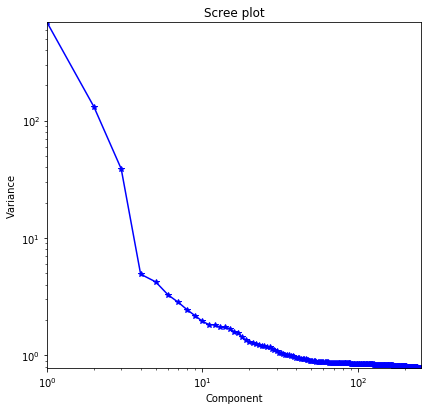

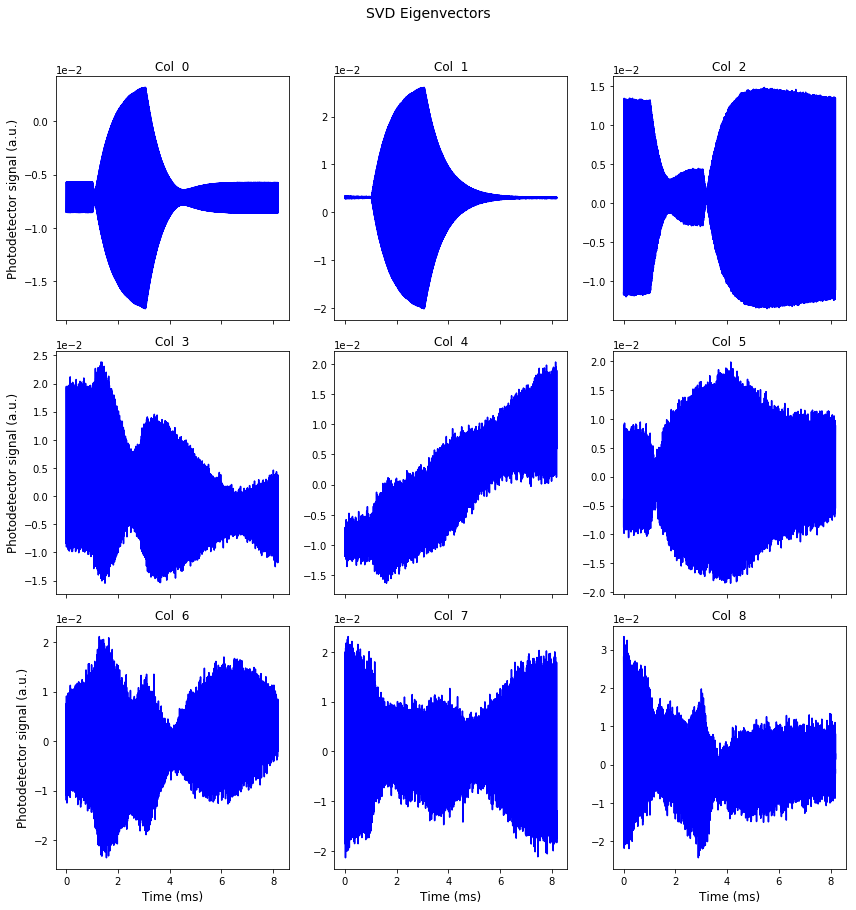

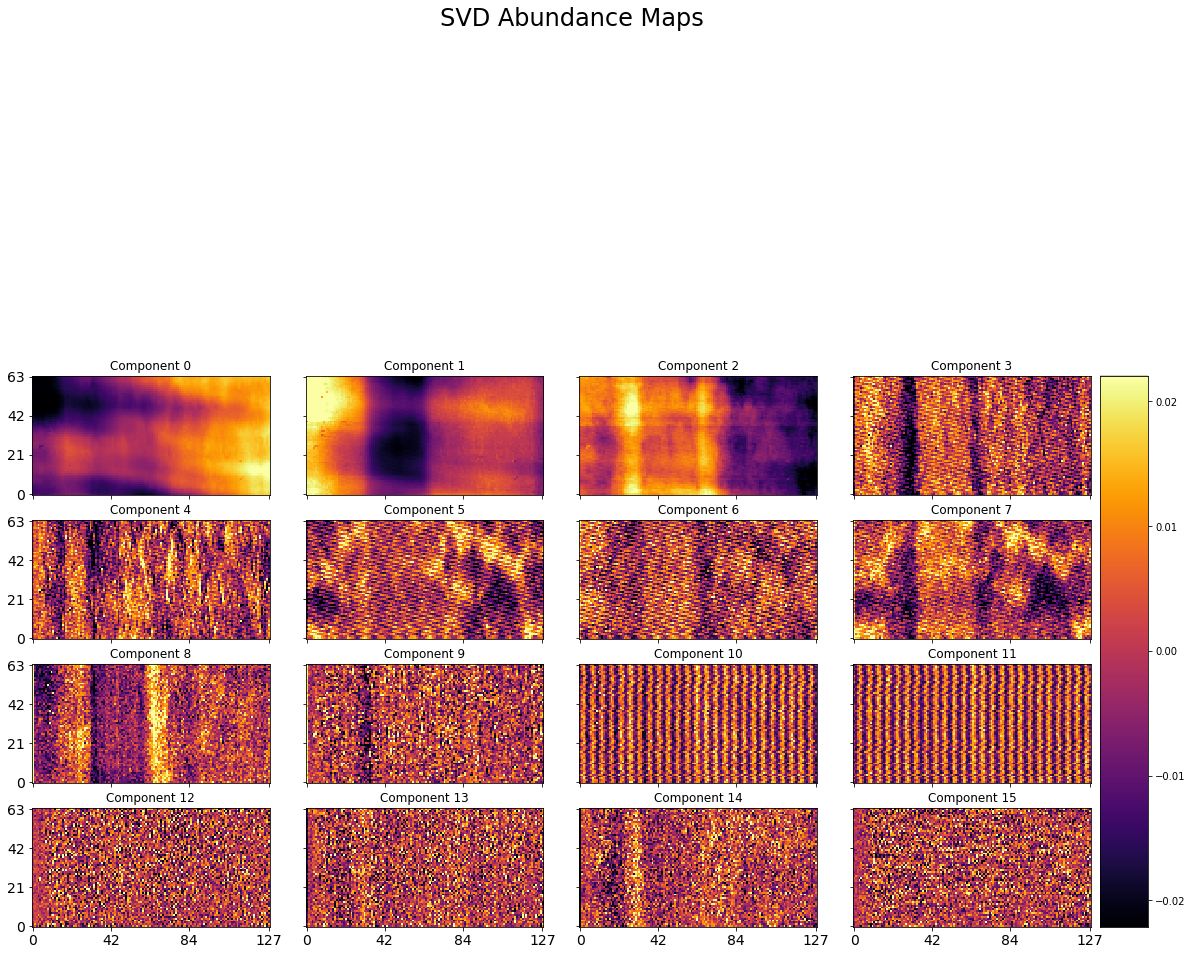

In [28]:
if do_SVD_denoise:
    # Since the two spatial dimensions (x, y) have been collapsed to one, we need to reshape the abundance maps:
    abun_maps = np.reshape(h5_u[:,:25], (num_rows, num_cols,-1))

    # Visualize the variance / statistical importance of each component:
    usid.plot_utils.plot_scree(h5_s, title='Scree plot')

    if save_figure == True:
        plt.savefig(output_filepath+'\PCARawRaw_Scree_2.tif', format='tiff')


    # Visualize the eigenvectors:
    first_evecs = h5_v[:9, :]
    fig, axes = usid.plot_utils.plot_curves(t_vec_pix, first_evecs, line_colors=['r'], x_label='Time (ms)',
                                                    y_label='Photodetector signal (a.u.)', subtitle_prefix='Col ', num_plots=16,
                                                    title='SVD Eigenvectors',use_rainbow_plots=False)


    if save_figure == True:
        plt.savefig(output_filepath+'\PCARawRaw_Eig_2.tif', format='tiff')


    # Visualize the abundance maps:
    usid.plot_utils.plot_map_stack(abun_maps, num_comps=16, title='SVD Abundance Maps', reverse_dims=True,
                                 color_bar_mode='single', cmap='inferno', title_yoffset=0.95)


    if save_figure == True:
        plt.savefig(output_filepath+'\PCARawRaw_Loading_2.tif', format='tiff')


        skree_sum = np.zeros(h5_s.shape)


Above you see the Skree plot, as well as the first 9 Eigenvectors and abundance maps for the Fourier filtered PD response.

The eigenvectors are representatitive of tip displacement vs time per pixel. The cantilever response to the pulse wave (plotted earlier) is complex, a mixture of inherent cantilever dynamics and true electrostatic interactions.

The abundance maps can clearly discern locations in the sample corresponding the source and drain electrode under the sample. Interestingly, the second and higher components indicate spatial variability in the region between electrodes which can be indicitive of space charge region dynamics at the interfaces

Note this method is purely statistical and produces non-physical components. Caution should be taken when attempting to interpret eigenvectors and abundance maps from SVD decomposition....actually...you probably shouldnt try to interpret them.

Nonetheless, for KPFM, and non-contact SPM in general, as is shown here the data can usually be well described (>90% information retention)by the first few components and typically you can learn valuable information on the basic trends, or spatio temporal behavior of your sample. But caution should be taken when trying to interpret these behaviours in a physical sense.

In [29]:
if do_SVD_denoise:
    for i in range(h5_s.shape[0]): 
        skree_sum[i] = np.sum(h5_s[:i])/np.sum(h5_s)

    plt.figure()
    plt.plot(skree_sum[1:-1]*100, 'o')
    plt.xlabel("Component")
    plt.ylabel("Information Content (%)")
    plt.tight_layout()
    print('We can plot the components as a percentage of the information in the entire data set ')
    
    print('Need to include', skree_sum[skree_sum<0.8].shape[0],'components for 80% information retention')
    print('Need to include', skree_sum[skree_sum<0.9].shape[0],'components for 90% information retention')
    print('Need to include', skree_sum[skree_sum<0.95].shape[0],'components for 95% information retention')
    print('')
    if save_figure == True:
        plt.savefig(output_filepath+'\Skree%.tif', format='tiff')    
   
    ##note I probably should write these to file as I am just demonstrating SVD denoising.
    clean_components=range(0,10)
    test=px.processing.svd_utils.rebuild_svd(h5_resh, components=clean_components)

    PCAClean1=np.reshape(test,(num_rows*num_cols,-1))

    clean_components=range(0,187)
    test=px.processing.svd_utils.rebuild_svd(h5_resh, components=clean_components)
    PCAClean2=np.reshape(test,(num_rows*num_cols,-1))

We can plot the components as a percentage of the information in the entire data set 
Need to include 9 components for 80% information retention
Need to include 121 components for 90% information retention
Need to include 187 components for 95% information retention

Reconstructing in batches of 2457 positions.
Batchs should be 767.9062271118164 Mb each.
Completed reconstruction of data from SVD results.  Writing to file.
Done writing reconstructed data to file.
Reconstructing in batches of 131 positions.
Batchs should be 765.624698638916 Mb each.
Completed reconstruction of data from SVD results.  Writing to file.
Done writing reconstructed data to file.


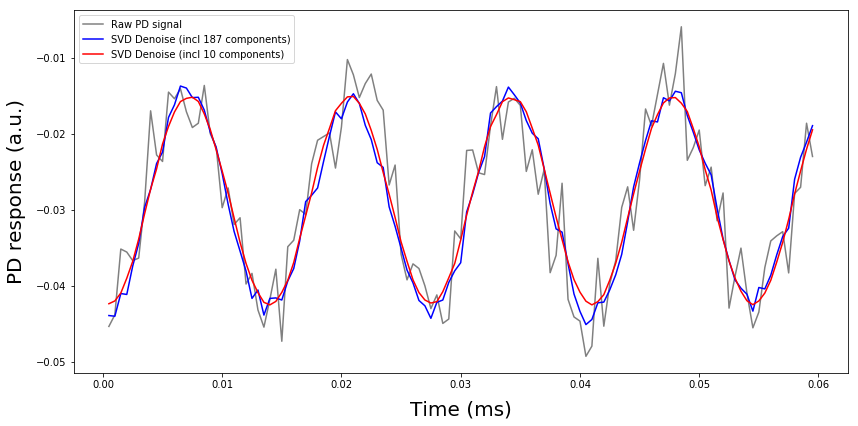

In [47]:
lfontsize=20
labelfont=14

plt.figure(1, figsize=(12, 6))
plt.plot(t_vec_pix,h5_resh[50,:],'grey',label='Raw PD signal')
plt.plot(t_vec_pix,PCAClean2[50,:],'b',label='SVD Denoise (incl 187 components)')
plt.plot(t_vec_pix,PCAClean1[50,:],'r',label='SVD Denoise (incl 10 components)')
plt.xlabel("Time (ms)",fontsize=lfontsize, labelpad=10)
plt.ylabel("PD response (a.u.)",fontsize=lfontsize, labelpad=10)
plt.legend(fontsize=labelfont, loc='lower left' )
plt.tight_layout(pad=1.0, w_pad=1.0, h_pad=1.0)
if save_figure == True:
    
        plt.savefig(output_filepath+'\SVDDenoiseA.tif', format='tiff')
        
n1=1
n2=120

plt.figure(2, figsize=(12, 6))
plt.plot(t_vec_pix[n1:n2],h5_resh[50,n1:n2],'grey',label='Raw PD signal')
plt.plot(t_vec_pix[n1:n2],PCAClean2[50,n1:n2],'b',label='SVD Denoise (incl 187 components)')
plt.plot(t_vec_pix[n1:n2],PCAClean1[50,n1:n2],'r',label='SVD Denoise (incl 10 components)')
plt.xlabel("Time (ms)",fontsize=lfontsize, labelpad=10)
plt.ylabel("PD response (a.u.)",fontsize=lfontsize, labelpad=10)
plt.legend(fontsize=10, loc='upper left' )
plt.tight_layout(pad=1.0, w_pad=1.0, h_pad=1.0)
if save_figure == True:
        plt.savefig(output_filepath+'\SVDDenoiseB.tif', format='tiff')

**Above you can see the net effect of denoizing (or rebuilding) the data on a random pixel of data; from a small (10) and larger (187) number of components. From the Skree we know that 10 components corresponds to ~80% information retention, whereas for 187 components corresponds to ~95% information retention. Practically, the cantilever behaviour is similar in both; however less components lead to less noise in the data. BUT...caution should be used when applying these approaches such that information is not lost. However, there can be comfort in the fact that during all of these processes we still retain the full, raw, and unprocessed data. This is never lost.**


### Step (2b) Denoising: Example 2 Fourier Filtering

* Here you can play with Filters and Noise Tresholds to find the optimal filter settings  

* First we test on a single row of data. Then once we have found the optimal filer settings we can apply to the full dataset.

* Notice: I am Filtering the raw data, not the PCA filtered data. Although...really its up to you if you want to use a combination of both in series. **AGAIN the goal is to denoize without information loss** 

In [31]:
# Test filter on a single line:
row_ind = 7

# Noise tolerance used for tresholding
noise_tolerance=0.000007
    
if Filter_data:
    # Set Filter parameters here:
    num_spectral_pts = h5_main.shape[1]
    
    ##############################################################################################################################
    #### Here you can play with Low Pass Filter
    ################################################################################################################
    lpf = px.processing.fft.LowPassFilter(num_pts, samp_rate, 180E+3) # low pass filter
    
     ##############################################################################################################################
    #### Here you can play with Noise band filter
    ################################################################################################################
    nbf = px.processing.fft.NoiseBandFilter(num_pts, samp_rate, [125E+3,45E+3, 50E+3, 5E+3, 100E+3, 165E+3], [2E+3,5E+3, 5E+3, 20E+3, 5E+3, 5E+3 ])
    
    ################################################################################################################################
    #### Here you can play with Noise Noise tolerance
    ################################################################################################################
     
   
    
    freq_filts = [lpf, nbf]
   
   
  
    excit_wfm = h5_spec_vals[-1]

    filt_line, fig_filt, axes_filt = px.processing.gmode_utils.test_filter(h5_main[row_ind], 
                                                                           frequency_filters=freq_filts, 
                                                                           noise_threshold=noise_tolerance, 
                                                                           show_plots=True)
    plt.tight_layout(pad=1.0, w_pad=1.0, h_pad=1.0)



#### Here you can take a look at your filtered data in the time domain at some random pixels

I show the excitation wave here for reference. This is the bias sent to the source electrode at every pixel. <br> Next is show the raw data at random pixels and finally the Fourier filtered data


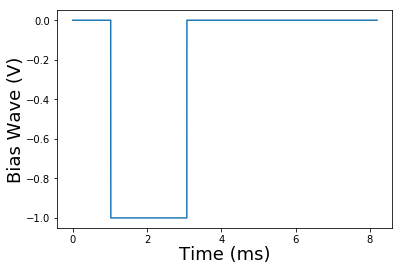

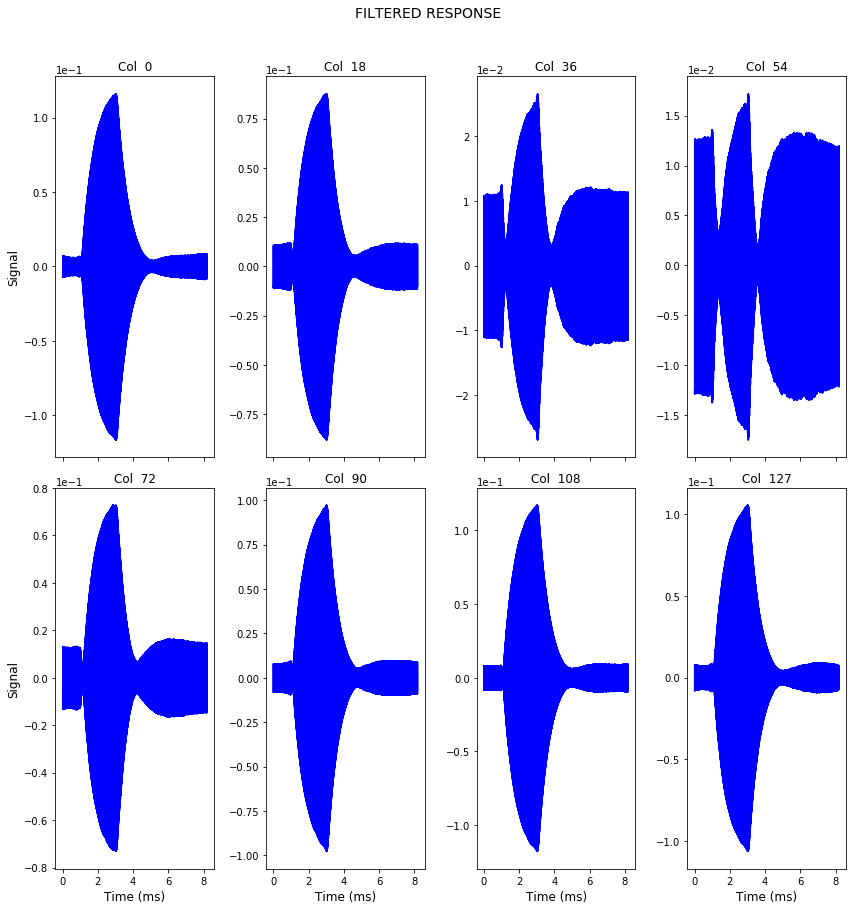

In [32]:
if Filter_data:
    # Test filter on a single line:
    plt.figure()
    plt.plot(t_vec_pix,pulse_wave)
    plt.xlabel('Time (ms)', fontsize=18, labelpad=1)
    plt.ylabel('Bias Wave (V)', fontsize=18, labelpad=1)
    
    
    print("I show the excitation wave here for reference. This is the bias sent to the source electrode at every pixel. <br> Next is show the raw data at random pixels and finally the Fourier filtered data")

      
    raw_pix=np.reshape(h5_main[row_ind],[num_cols,-1])
    
    filt2_pix=np.reshape(filt_line,[num_cols,-1])
    
     
    fig_loops, axes_loops = usid.plot_utils.plot_curves(t_vec_pix,raw_pix, line_colors=['b'], x_label='Time (ms)',
                                                        y_label='Signal', subtitle_prefix='Col ', num_plots=8,
                                                        title='RAW RESPONSE',use_rainbow_plots=False)
    
    fig_loops, axes_loops = usid.plot_utils.plot_curves(t_vec_pix,filt2_pix, line_colors=['r'], x_label='Time (ms)',
                                                    y_label='Signal', subtitle_prefix='Col ', num_plots=8,
                                                    title='FILTERED RESPONSE',use_rainbow_plots=False)

  

In [94]:
lfontsize=20
labelfont=14
raw_pix1=raw_pix[1,:]-np.mean(raw_pix[1,:],0)
plt.figure(1, figsize=(12, 6))
plt.plot(t_vec_pix,raw_pix1,'grey',label='Raw PD signal')
plt.plot(t_vec_pix,filt2_pix[1,:],'b',label='Fourier Filtered Data')

plt.xlabel("Time (ms)",fontsize=lfontsize, labelpad=10)
plt.ylabel("PD response (a.u.)",fontsize=lfontsize, labelpad=10)
plt.legend(fontsize=labelfont, loc='lower left' )
plt.tight_layout(pad=1.0, w_pad=1.0, h_pad=1.0)
if save_figure == True:
    
        plt.savefig(output_filepath+'\FourierDenoiseA.tif', format='tiff')
        
n1=1
n2=120

plt.figure(2, figsize=(12, 6))
plt.plot(t_vec_pix[1:250],raw_pix1[1:250],'grey',label='Raw PD signal')
plt.plot(t_vec_pix[1:250],filt2_pix[1,1:250],'b',label='Fourier Filtered Data')
plt.xlabel("Time (ms)",fontsize=lfontsize, labelpad=10)
plt.ylabel("PD response (a.u.)",fontsize=lfontsize, labelpad=10)
plt.legend(fontsize=10, loc='upper left' )
plt.tight_layout(pad=1.0, w_pad=1.0, h_pad=1.0)
if save_figure == True:
        plt.savefig(output_filepath+'\FourierDenoiseB.tif', format='tiff')

**Alternatively, we can plot the cantilever displacement vs the excitation voltage**

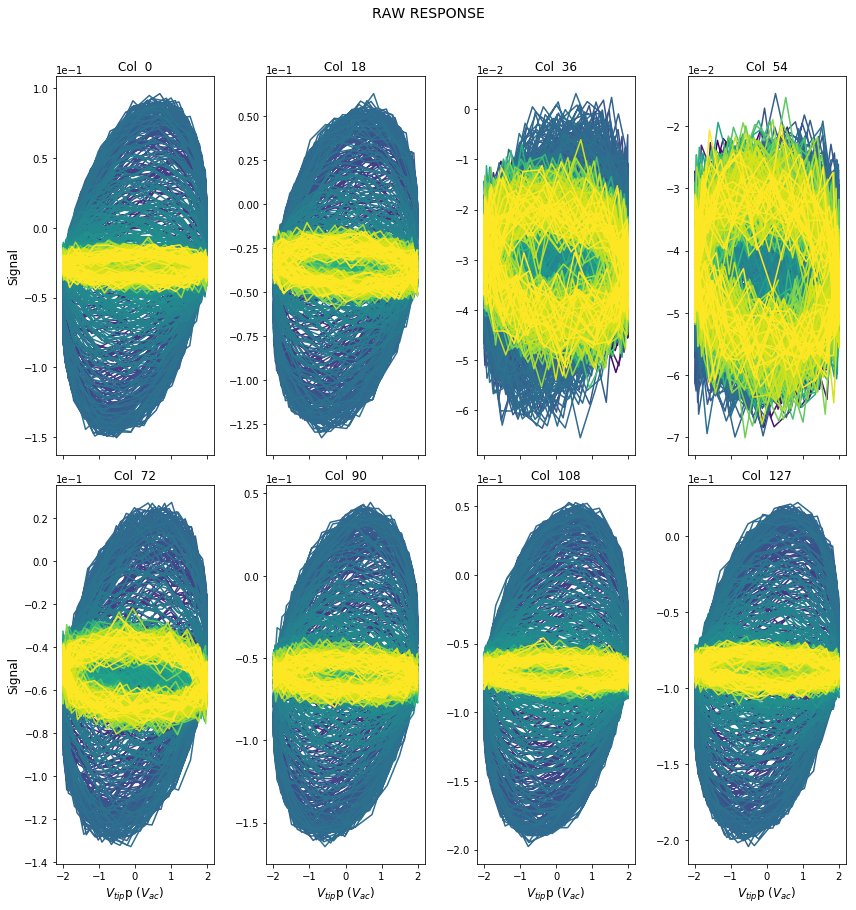

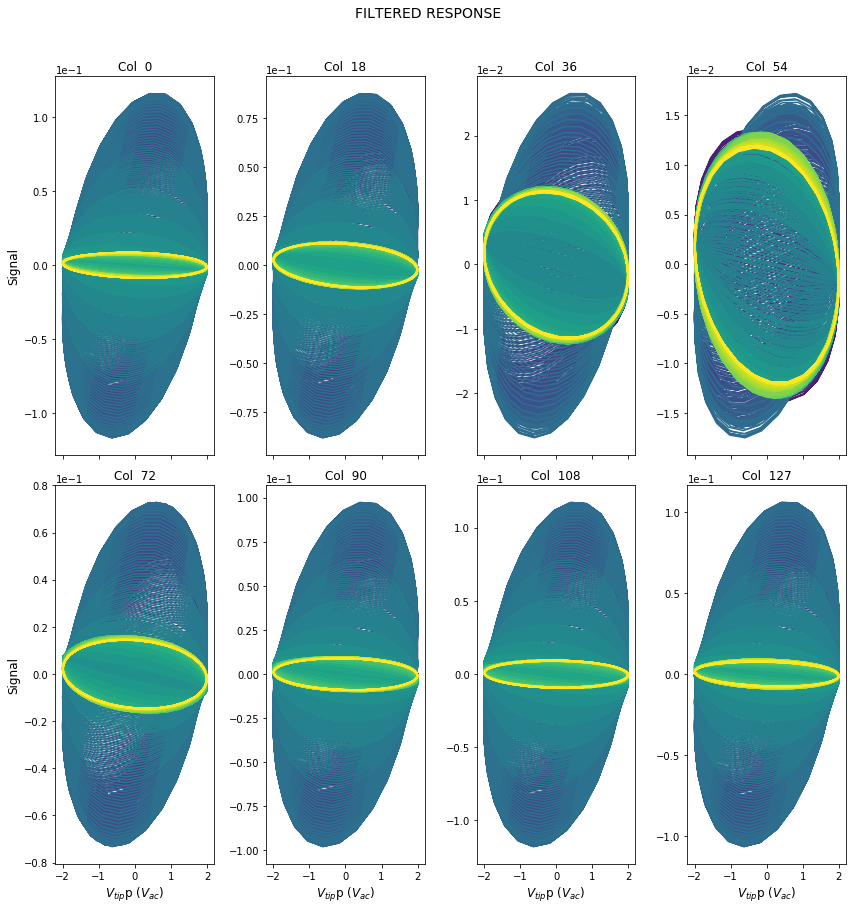

In [96]:

if Filter_data:
    fig_loops, axes_loops = usid.plot_utils.plot_curves(pixel_ex_wfm,raw_pix, line_colors=['r'], x_label='$V_{tip}$p ($V_{ac}$)',
                                                        y_label='Signal', subtitle_prefix='Col ', num_plots=8,
                                                        title='RAW RESPONSE',use_rainbow_plots=True)
    if save_figure == True:
        plt.savefig(output_filepath+'\FourierDenoiseC.tif', format='tiff')
        
    fig_loops, axes_loops = usid.plot_utils.plot_curves(pixel_ex_wfm,filt2_pix, line_colors=['r'], x_label='$V_{tip}$p ($V_{ac}$)',
                                                        y_label='Signal', subtitle_prefix='Col ', num_plots=8,
                                                        title='FILTERED RESPONSE',use_rainbow_plots=True)
    if save_figure == True:
        plt.savefig(output_filepath+'\FourierDenoiseD.tif', format='tiff')

In [95]:
output_filepath

'C:\\Users\\lz1\\Desktop\\pySPM-on-SPM-master\\pySPM-on-SPM-master\\ImageData'

**Above is an example of filtered data vs Vac. The color scale respresents time (0-8 ms in this case). The plots are pretty non-sensical. This is because the signal is a mixture of the electrostatic force and the cantilever dynamics in response to that force.**

## Now we can Fourier filter the entire data set


In [52]:
   
if Filter_data:
    parm_dict = dict()
    for filter in freq_filts:
        parm_dict.update(filter.get_parms())
    parm_dict['noise_threshold'] = noise_tolerance
    parm_dict['num_pix'] = h5_main.shape[0]
    h5_filt_grp = usid.hdf_utils.check_for_old(h5_main, 'FFT_Filtering', new_parms=parm_dict)
   
    
    if len(h5_filt_grp) > 0:
        print('Taking previously filtered results')
        h5_filt_grp = h5_filt_grp[-1]
    else:
        print('FFT filtering not performed on this dataset. Filtering now:')


    sig_filt = px.processing.SignalFilter(h5_main, frequency_filters=freq_filts, noise_threshold=noise_tolerance,
                                              write_filtered=True, write_condensed=False, num_pix=1, verbose=True)

    h5_filt_grp = sig_filt.compute()

    h5_filt = h5_filt_grp['Filtered_Data']
   
    
    
elif not Filter_data:
    
    
    h5_filt = px.hdf_utils.find_dataset(hdf, 'Filtered_Data')[-1]
    
    

FFT filtering not performed on this dataset. Filtering now:
Allowed to read 325 pixels per chunk
Allowed to use up to 3 cores and 4096 MB of memory
Consider calling test() to check results before calling compute() which computes on the entire dataset and writes back to the HDF5 file
Allowed to read 108 pixels per chunk
Checking for duplicates:
Creating datagroup and datasets
h5 group and file OK
quantity, units, main_data_name all OK
Selected empty dataset creation. OK so far
Provided h5 position indices and values OK
Passed all pre-tests for creating spectroscopic datasets
Indices:
[[0]]
Values:
[[1.]]
Starting to write Region References to Dataset /Measurement_000/Channel_000/Raw_Data-FFT_Filtering_001/Noise_Spec_Indices of shape: (1, 1)
About to write region reference: arb : (slice(0, 1, None), slice(None, None, None))
Comparing (slice(0, 1, None), slice(None, None, None)) with h5 dataset maxshape of (1, 1)
Region reference tuple now: [slice(0, 1, None), slice(None, None, None)]
Wro

In [53]:
usid.hdf_utils.print_tree(hdf)

/
├ Measurement_000
  ---------------
  ├ CPD_000
    -------
    ├ CPD
    ├ CPD-Cluster_000
      ---------------
      ├ Cluster_Indices
      ├ Cluster_Values
      ├ Labels
      ├ Mean_Resp_Pos_Indices
      ├ Mean_Resp_Pos_Values
      ├ Mean_Response
    ├ CPD-Cluster_001
      ---------------
      ├ Cluster_Indices
      ├ Cluster_Values
      ├ Labels
      ├ Mean_Resp_Pos_Indices
      ├ Mean_Resp_Pos_Values
      ├ Mean_Response
    ├ CPD-SVD_000
      -----------
      ├ Position_Indices
      ├ Position_Values
      ├ S
      ├ Spectroscopic_Indices
      ├ Spectroscopic_Values
      ├ U
      ├ V
    ├ CPDExpFitting_000
      -----------------
      ├ Position_Indices
      ├ Position_Values
      ├ Spectroscopic_Indices
      ├ Spectroscopic_Values
      ├ fit_param
    ├ CPDExpFitting_001
      -----------------
      ├ Position_Indices
      ├ Position_Values
      ├ Spectroscopic_Indices
      ├ Spectroscopic_Values
      ├ fit_param
    ├ CPDExpFitting_on_000
     

## Step 3. Fast Free Force Reconstruction 

Below we perform fast free recovery of the electrostatic force by dividing the filtered response by the effective transfer function. We futher set a noise treshold, for the data to be included in the iFFT transform into the time domain. This is important, because otherwise you would transform unphysical noise into the time domain response.

At this point we also need to correct for the phase offset due to the BNC cables etc. Currently, I use ad-hoc methods to find the approriate phase offset (just like you would on a LIA) and noise treshold. Here I use what I found to be optimal settings for this experiment. I am sure there is a way to automate this optimization step...if you find one feel free to email me :). Ill buy you a beer.

       
#### (3) Fast Free Force Reconstruction   
**(3a)** Divides filtered displacement Y(w) by the effective transfer function (H(w)). <br>
**(3b)** iFFT the response above a user defined noise floor to recovery Force in time domain.<br>



In [56]:
ph=-0.52 #Phase offset
Noiselimit = 5; #Phase offset

signal_ind_vec=np.arange(w_vec.size)
ind_drive = (np.abs(w_vec*1e3-ex_freq)).argmin()

if DO_F3R:
    
    #########################################################################################################
    ### Function
    #########################################################################################################
    def scale_by_tune(filt_vec, w_vec, ph, ind_drive, TF_norm):
        G=np.zeros(w_vec.size,dtype=complex)
        signal_keep=[]
            
        tmp_time=filt_vec-np.mean(filt_vec)
        tmp=np.fft.fftshift(np.fft.fft(tmp_time))
        signal_keep = np.argwhere(np.abs(tmp)>=Noiselimit).squeeze()
        tmp *= np.exp(-1j*w_vec*1E3/(w_vec[ind_drive]*1E3)*ph)
        G[signal_keep]=tmp[signal_keep]
        G_time=np.real(np.fft.ifft(np.fft.ifftshift(G/TF_norm)))
        
        return G_time
    

    
    #########################################################################################################
    ### Perform F3R in parallel -- You should change n_jobs to match #cores you want to use 
    #########################################################################################################
    
    num_cores=4
    raw_data = h5_filt[()]
    
    scaling_kwargs = {'w_vec': w_vec2,
                     'ph': ph,
                     'ind_drive': ind_drive,
                     'TF_norm': TF_norm}
    
    results = usid.processing.parallel_compute(raw_data, scale_by_tune, 
                                               cores=num_cores, 
                                               func_kwargs=scaling_kwargs)
    
    G_time = np.array(results)

    del results
    
    #########################################################################################################
    ### Storing and Reshaping
    #########################################################################################################
    
    F3R_pos_vals=np.squeeze(h5_main.h5_pos_vals.value)
    F3R_pos_inds=h5_main.h5_pos_inds
    F3R_spec_vals = np.squeeze(h5_main.h5_spec_vals.value)
    F3R_spec_inds = h5_main.h5_spec_inds 

    F3R_pos_dim = px.hdf_utils.Dimension('Rows', 'um', F3R_pos_vals)
    F3R_spec_dim = px.hdf_utils.Dimension('Bias', 'V', F3R_spec_vals)

    F3R_grp = px.hdf_utils.create_indexed_group(h5_main.parent, 'F3R_Results')
    
    px.hdf_utils.write_simple_attrs(F3R_grp, {'Noise Level': Noiselimit,
                                                'Phase': ph})
    
    h5_F3R = px.hdf_utils.write_main_dataset(F3R_grp, G_time, 'F3R_data', 
                                           'Response', 'a.u.',
                                          F3R_pos_dim, F3R_spec_dim)
    hdf.file.flush()
    
elif not DO_F3R:   
    G_time = px.hdf_utils.find_dataset(hdf, 'F3R_data')[-1]

###################################
### Check a single row
###################################

raw=G_time[row_ind].reshape(-1,pixel_ex_wfm.size)



fig, axes = usid.plot_utils.plot_curves(pixel_ex_wfm, raw, line_colors=['r'], x_label='Voltage (V$_{ac}$)',
                                                y_label='Deflection (a.u.)', subtitle_prefix='Col ', num_plots=8,
                                                title='F3R results',use_rainbow_plots=True)

#### EUREKA!!!

#### Above are some plots of the Displacement vs Voltage for some pixels after the force recovery procedure is carried out. We have recoved the parabola!! This is the expected functional form of the electrostatic force. We can fit this data to a 2nd order polynomial to find the Contact potential difference (CPD) and a measure of the capacitance gradient.

#### If I wanted to convert these plots to Force (N) I could do so using the calibrated constants of the K-spring constant. However, in G-KPFM I am interesteed in extracted CPD so it is unnessary to do this.

In [57]:
###################################
### Reshape Data
###################################

G_time = px.hdf_utils.find_dataset(hdf, 'F3R_data')[-1]
h5_resh_grp = px.core.hdf_utils.find_results_groups(G_time,'F3R_data')

if len(h5_resh_grp) > 0:
    print('Taking previously reshaped results')
    h5_resh_grp = h5_resh_grp[-1]
    h5_resh = px.hdf_utils.find_dataset(hdf,'Reshaped_Data')[0]
    
else:
    print('Reshape not performed on this dataset. Reshaping now:')
    scan_width = 1
    h5_resh = px.processing.gmode_utils.reshape_from_lines_to_pixels(h5_F3R, pixel_ex_wfm.size, scan_width / num_cols)
    h5_resh_grp = h5_resh.parent

Taking previously reshaped results



### Parabolic Fitting of Cleaned Data

#### Next we do parabolic fitting to quanitfy CPD. Notice at this point we have a 3D data set of force(x,y,time). We recovery the parabola for every period of the AC voltage excitation. This means the output of fit is a 3D data set (x,y,num_pnts/points_per_period). Its also quite possible that we can determine the CPD on smaller timescales (i.e. fit to a partial parabola). 


No handles with labels found to put in legend.


Text(0,0.5,'Displacement (a.u.)')

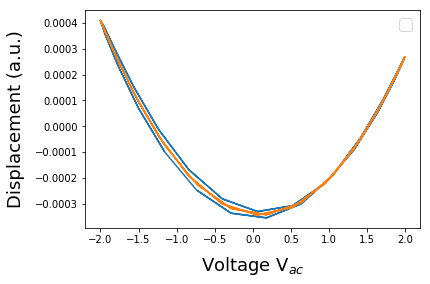

In [58]:
##########################################
### DO parabolic fitting of single point
##########################################

time_per_osc = 1/parms_dict['BE_center_frequency_[Hz]']
IO_rate = parms_dict['IO_rate_[Hz]']

N_points_per_pixel = parms_dict['num_bins']
pxl_time = N_points_per_pixel/IO_rate
num_periods = int(pxl_time // (time_per_osc*2))
pnts_per_per = int(N_points_per_pixel // num_periods)

time = np.linspace(0,pxl_time,num_periods)

deg = 2

n = 2
m = 2
k4 = 22

resp = np.zeros(k4,dtype="float32")
resp = h5_resh[m][pnts_per_per*k4:pnts_per_per*(k4+1)]

resp = (resp-np.mean(resp))
resp =np.float32(resp)
V_per_osc = pixel_ex_wfm[pnts_per_per*k4:pnts_per_per*(k4+1)]
p1,s = npPoly.polyfit(V_per_osc,resp,deg,full=True)
y1 = npPoly.polyval(V_per_osc,p1)

plt.figure()
plt.plot(V_per_osc, resp)
plt.plot(V_per_osc, y1)
plt.legend(fontsize=16)
plt.xlabel('Voltage V$_{ac}$', fontsize=18, labelpad=10)
plt.ylabel('Displacement (a.u.)', fontsize=18, labelpad=10)

## Fit the full dataset

#### If you run this cell it will take several minutes to complete. We reduce the fitting time by using parallel processing made extremely easy using pycroscopy. If you are having problems running it then you might want to change the number of cores you are using for fitting.

In [59]:
if do_para_fit:

    def fit_cleaned(data_vec, pixel_ex_wfm, pnts_per_per, num_periods, deg):
        fit = np.zeros([num_periods, deg+1])
        for k4 in range(num_periods):#osc_period
            resp=data_vec[pnts_per_per*k4:pnts_per_per*(k4+1)]
            resp=resp-np.mean(resp)
            V_per_osc=pixel_ex_wfm[pnts_per_per*k4:pnts_per_per*(k4+1)]
            p1,s=npPoly.polyfit(V_per_osc,resp,deg,full=True)
            y1=npPoly.polyval(V_per_osc,p1)           

            fit[k4,:]=p1
        return fit
    
    fit_cleaned_dict = {'pixel_ex_wfm': pixel_ex_wfm,
                        'pnts_per_per': pnts_per_per,
                        'num_periods': num_periods,
                        'deg': deg}
    
    results = usid.processing.parallel_compute(h5_resh[()], fit_cleaned, 
                                               cores=num_cores,
                                               func_kwargs=fit_cleaned_dict)
    
    #change n_jobs below as approraite to the number of cores you want to use
    wHfit3 = np.array(results)

    CPD=0.5*np.divide(wHfit3[:,:,1],wHfit3[:,:,0]) 

    del results
    
    ##########################################
    ### Save CPD to HD5 (need to change to save all fit)
    ##########################################
    
        
    CPD_pos_vals=np.arange(0,num_rows*num_cols)
    CPD_spec_vals = time 

    CPD_pos_dim = px.hdf_utils.Dimension('Rows', 'um', CPD_pos_vals)
    CPD_spec_dim = px.hdf_utils.Dimension('Time', 'S', CPD_spec_vals)

    CPD_grp = px.hdf_utils.create_indexed_group(h5_main.parent.parent, 'CPD')
    
    h5_CPD = px.hdf_utils.write_main_dataset(CPD_grp, CPD, 'CPD', 
                                             'CPD', 'V',
                                             pos_dims, CPD_spec_dim)
    
    hdf.file.flush()
    
elif not do_para_fit:
    h5_CPD = px.hdf_utils.find_dataset(hdf,'CPD')[-1]
    CPD=np.float32(h5_CPD[:])
    

In [60]:
print("The CPD dataset shape is now:")
print (CPD.shape)

print("Which is rows x cols, number of CPD readouts per pixel. In this case our CPD resolution is:")
print (time[-1]/CPD[1].shape)


The CPD dataset shape is now:
(8192, 302)
Which is rows x cols, number of CPD readouts per pixel. In this case our CPD resolution is:
[2.71258278e-05]


## Data Visualization 
#### Plot single point

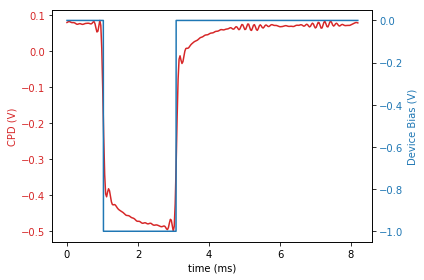

In [62]:
time = np.linspace(0,pxl_time,num_periods)

##########################################
### Plot Single Point
##########################################

test=CPD[150,:]
time=np.linspace(0.0,pxl_time,num_periods)

fig, ax1 = plt.subplots()
color = 'tab:red'
ax1.set_xlabel('time (ms)')
ax1.set_ylabel('CPD (V)', color=color)
ax1.plot(time*1000, test, color=color)
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis


color = 'tab:blue'
ax2.set_ylabel('Device Bias (V)', color=color)  # we already handled the x-label with ax1
ax2.plot(t_vec_pix,pulse_wave, color=color)
ax2.tick_params(axis='y', labelcolor=color)

fig.tight_layout()  # otherwise the right y-label is slightly clipped
#plt.show()


if save_figure == True:
  plt.savefig(output_filepath+'\CPD_vs_time.tif', format='tiff')

      



# Here do some plotting

#### Generating CPD rate images ####


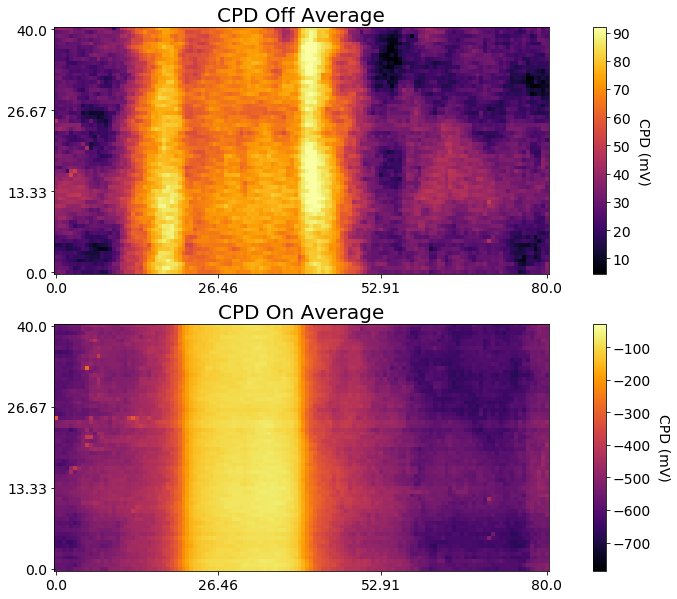

In [64]:

d1=np.where(np.abs(pulse_wave)>0) 

pf_on =t_vec_pix[d1[0][0]]
pf_off =t_vec_pix[d1[0][-1]]

bias_on_time=[pf_on,pf_off]

dtCPD = pxl_time/(CPD.shape[1]-1) #dt for the CPD since not same length as raw data
p_on = int(bias_on_time[0]*1e-3 / dtCPD) +1
p_off = int(bias_on_time[1]*1e-3 / dtCPD) 

time_on = time[p_on:p_off]
time_off = time[p_off:]   # last point is sometimes NaN for some reason


# This will overwrite CPD_on_avg, etc that are loaded from the H5 file originally. Normally that is okay.

# Make CPD on and off, reshape into images by takign averages
CPD_on = CPD[:, p_on:p_off]
CPD_off = CPD[:, p_off:]


CPD_on_avg = np.zeros((num_rows, num_cols))
CPD_off_avg = np.zeros((num_rows, num_cols))


CPD_on_time = np.zeros((num_rows, num_cols))
CPD_off_time = np.zeros((num_rows, num_cols))

CPD_on_mag = np.zeros((num_rows, num_cols))
CPD_off_mag  = np.zeros((num_rows, num_cols))

print('#### Generating CPD rate images ####')
for r in np.arange(CPD_on_avg.shape[0]):

    for c in np.arange(CPD_on_avg.shape[1]):

        CPD_on_avg[r][c] = np.mean(CPD_on[r*num_cols + c,:])

        CPD_off_avg[r][c] = np.mean(CPD_off[r*num_cols + c,:])


deltaCPD = CPD_on_avg - CPD_off_avg


#1e3 to put in mV
mx = np.max([np.max(CPD_on_avg), np.max(CPD_off_avg)])*1e3
mn = np.min([np.min(CPD_on_avg), np.min(CPD_off_avg)])*1e3
xv = np.linspace(0,img_length*1e6, num_cols)
yv = np.linspace(0,img_height*1e6, num_rows)

# Plots the CPD averages
fig, a = plt.subplots(nrows=2, figsize=(20, 10))
_, cbar = px.plot_utils.plot_map(a[0], CPD_off_avg*1e3, cmap='inferno',  
                       x_vec=xv, y_vec = yv, stdevs = 2,
                       cbar_label='CPV (mV)')

cbar.set_label('CPD (mV)', rotation=270, labelpad=20)
a[0].set_title('CPD Off Average', fontsize=20)

_, cbar = px.plot_utils.plot_map(a[1], CPD_on_avg*1e3, cmap='inferno',  
                       x_vec=xv, y_vec = yv, stdevs = 2,
                       cbar_label='CPV (mV)')

cbar.set_label('CPD (mV)', rotation=270, labelpad=20)
a[1].set_title('CPD On Average', fontsize=20)


if save_figure == True:
    fig.savefig(output_filepath+'\CPDon_vs_off_noPCApost.eps', format='eps')
    fig.savefig(output_filepath+'\CPDon_vs_off_noPCApost.tif', format='tiff')

# some clean-up for plotting to remove curve-fit errors; only for setting color range
from scipy import signal
testC = signal.medfilt(CPD_on_time, kernel_size=[3,3])
testD = signal.medfilt(CPD_off_time, kernel_size=[3,3])

mnC = (np.mean(testC) - 2*np.std(testC))*1e3
mxC = (np.mean(testC) + 2*np.std(testC))*1e3
mnD = (np.mean(testD) - 2*np.std(testD))*1e3
mxD = (np.mean(testD) + 2*np.std(testD))*1e3
mn = np.min([mnC, mnD])
mx = np.max([mxC, mxD])

C:\Users\lz1\AppData\Local\Continuum\Anaconda3\lib\site-packages\matplotlib\figure.py:2267: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "
C:\Users\lz1\AppData\Local\Continuum\Anaconda3\lib\site-packages\matplotlib\pyplot.py:537: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


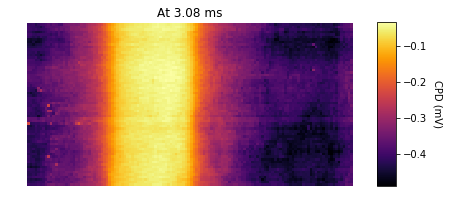

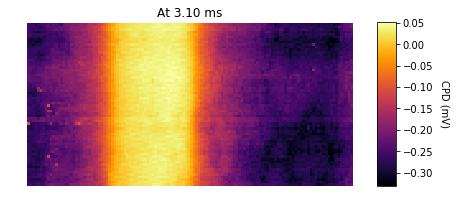

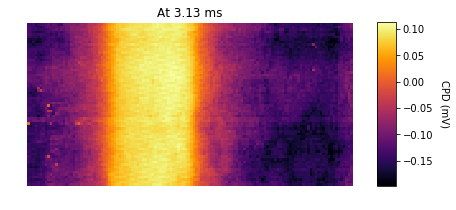

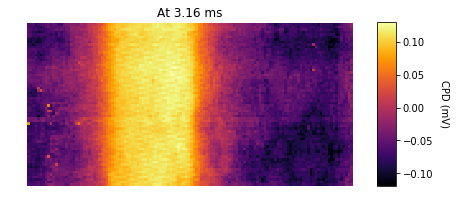

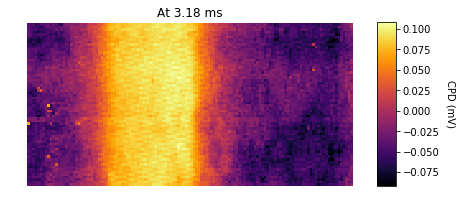

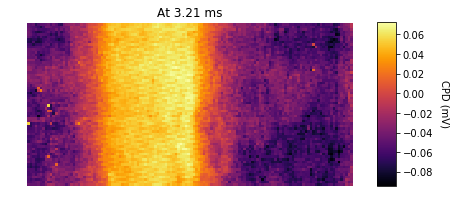

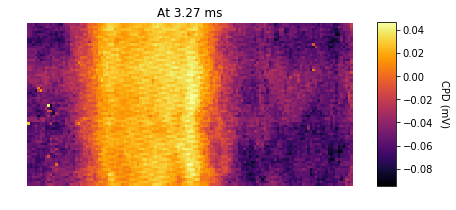

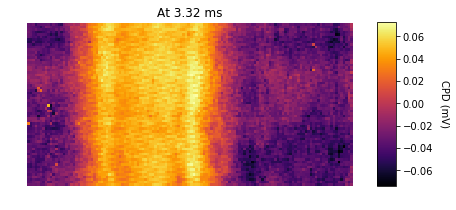

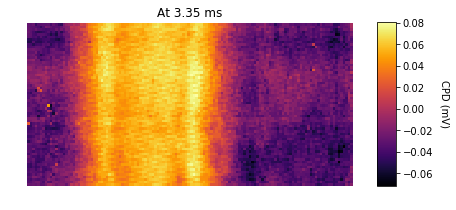

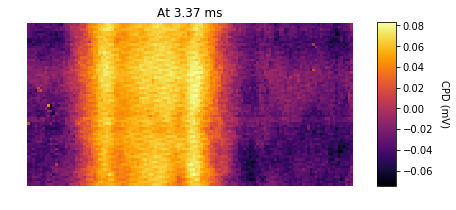

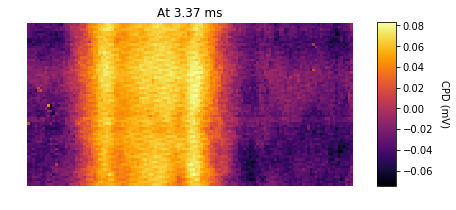

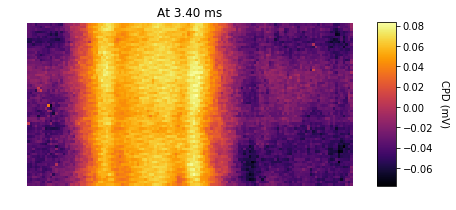

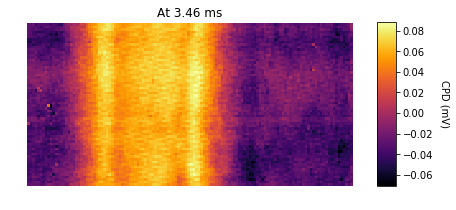

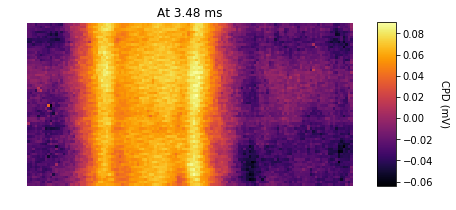

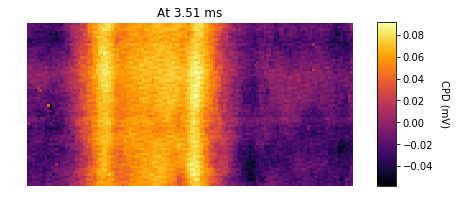

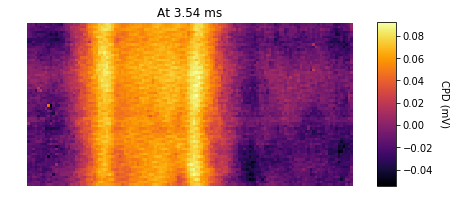

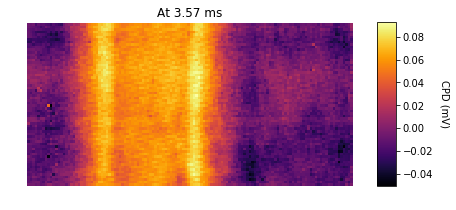

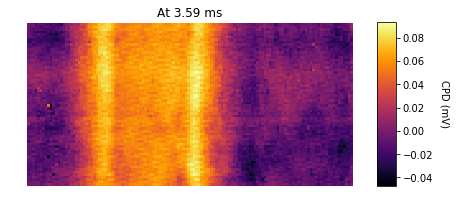

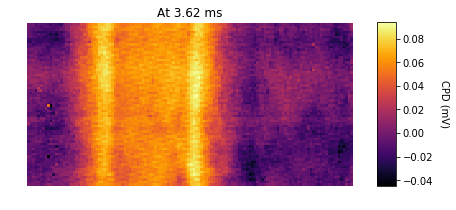

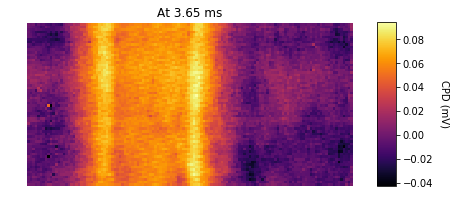

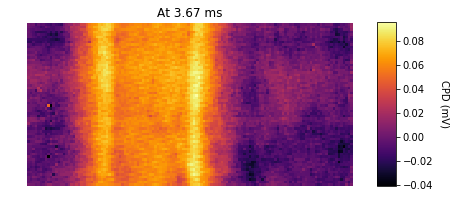

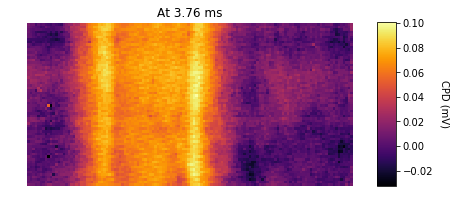

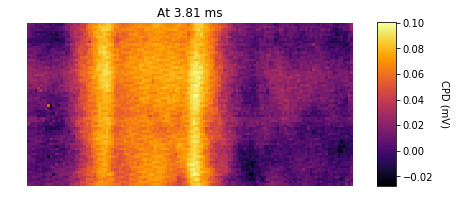

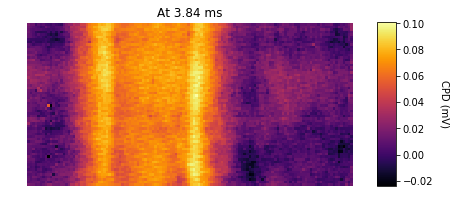

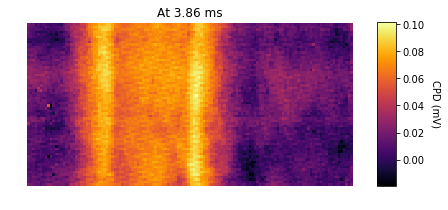

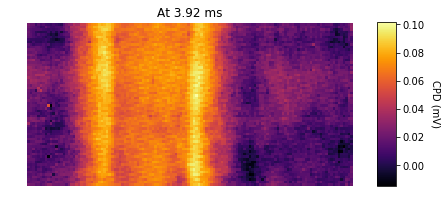

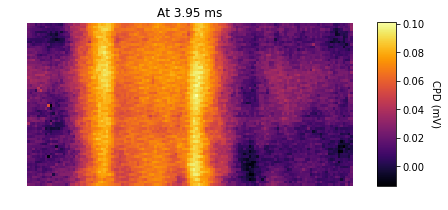

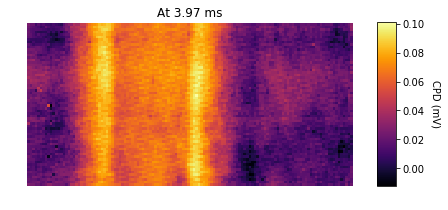

In [65]:


#%% CPD Time Slices
timeslice = np.floor(np.arange(3.1,4, .025) *1e-3/dtCPD)

# find correct mn and mx for color scale
# you can manually change mn and mx after running this block to maximize the contrast
CPD_mn = np.reshape(CPD[:, p_on+int((p_off-p_on)/2)], [64, 128])
mn = np.mean(CPD_mn) - 2.5*np.std(CPD_mn)
CPD_mx = np.reshape(CPD[:, p_off+int((CPD.shape[1]-p_off)/2)], [64, 128])
mx = np.mean(CPD_mx) + 3*np.std(CPD_mx)

#mn = -.13
#mx = -.0600
for k in timeslice:
    fig = plt.figure(figsize=(13,3))
    a = fig.add_subplot(111)
    CPD_rs = np.reshape(CPD[:, int(k)], [64, 128])
    im = a.imshow(CPD_rs, cmap='inferno', vmin=mn, vmax=mx)
    im = a.imshow(CPD_rs, cmap='inferno')
    a.set_axis_off()
    tl = '{0:.2f}'.format(k*dtCPD/1e-3)
    plt.title('At '+ tl + ' ms', fontsize=12)
    cx = fig.add_axes([0.7, 0.125, 0.02, 0.76])
    cbar = fig.colorbar(im, cax=cx)
    cbar.set_label('CPD (mV)', rotation=270, labelpad=16)
    #fig.savefig(output_filepath+'\CPDslice_' + tl + '_ms.eps', format='eps')
    plt.tight_layout(pad=1.0, w_pad=1.0, h_pad=1.0)
    fig.savefig(output_filepath+'\CPDslice_' + tl + '_ms.tif', format='tiff')

**Alternatively we can view cross sections vs time. In addition, we can calculate the Electric Field distribution by finding -dCPD/dx. To help smooth the data we apply a savgol_filter.**

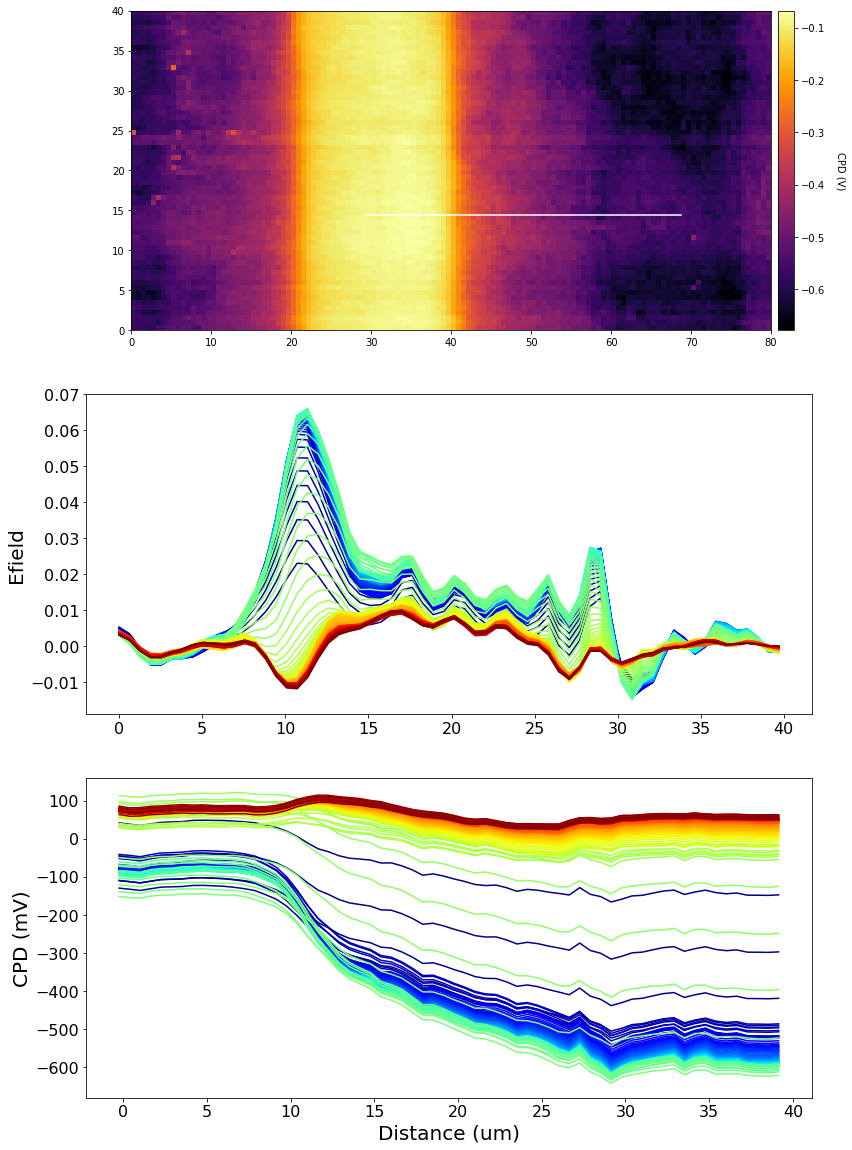

In [66]:
from scipy.signal import savgol_filter

img_width=img_length
wind_size=3
polyval=1
tick_fontsize=16
lb_fontsize=20
x_lim = np.linspace(0,img_width*1E6, num_cols)
dx=x_lim[1]-x_lim[0]

#%% Cross-sectional animation, setup

'''
Set the cooordinates to draw a line across here. 
1) Note these are in in length units (in microns here)! 
2) Rpts must have same start and finish. This segment only allows horizontal lines at this time. Sorry!
'''
cptslabels = [30, 70] #column points, row points
rptslabels = [15 ,20]

cpts = [int(i) for i in np.array(cptslabels) * (1e-6/ img_length) * num_cols]
rpts = [int(i) for i in np.array(rptslabels) * (1e-6/ img_height) * num_rows]

#cpts = [69, 76] #column points, row points
#rpts = [4, 4]
linecoords = np.arange(rpts[0]*num_cols + cpts[0], rpts[0]*num_cols + cpts[1])

clen = cpts[1] - cpts[0]
rlen = rpts[1] - rpts[0]
pxl_size = img_length/num_cols #meter length of a pixel
pxl_ht = img_height/num_rows #meter height of a pixel
dtCPD = pxl_time/CPD.shape[1] #dt for the CPD since not same length as raw data
p_on = int(bias_on_time[0]*1e-3 / dtCPD) 
p_off = int(bias_on_time[1]*1e-3 / dtCPD) 

ccoords = np.arange(cpts[0],cpts[1])
rcoords = np.arange(rpts[0],rpts[1])

time = np.linspace(0.0, pxl_time, CPD.shape[1])
xax = ccoords*pxl_size*1e6


fig, a = plt.subplots(nrows=3, figsize=(13, 20), facecolor='white')
im0 = a[0].imshow(CPD_on_avg, cmap='inferno', origin='lower',
                    extent=[0, img_length*1e6, 0, img_height*1e6])
cbar = plt.colorbar(im0, ax=a[0], orientation='vertical',
                    fraction=0.046, pad=0.01, use_gridspec=True)
cbar.set_label('CPD (V)', rotation=270, labelpad = 20)
a[0].plot(ccoords*pxl_size*1e6, rpts[0]*pxl_ht*1e6*np.ones(len(ccoords)), 'w')

ims = []


a[1].set_ylabel('Efield', fontsize=lb_fontsize)

a[2].set_xlabel('Distance (um)', fontsize=lb_fontsize)
a[2].set_ylabel('CPD (mV)', fontsize=lb_fontsize)

txtcoord = np.max(CPD[linecoords,0])*1e3

#Colorscale
# Here you should change this to best accentuate the contrast in the image. 
CPD_mn = np.reshape(CPD[:, p_on+int((p_off-p_on)/2)], [64, 128])
mn = np.mean(CPD_mn) - 3*np.std(CPD_mn)
CPD_mx = np.reshape(CPD[:, p_off+int((CPD.shape[1]-p_off)/2)], [64, 128])
mx = np.mean(CPD_mx) + 3*np.std(CPD_mx)

displays = np.array([1, p_on, int(p_on+(p_off-p_on)/2), p_off, num_periods-5])

n=12
displays = np.array([  p_off-(n*4),p_off-(n*3),p_off-(n*2), p_off-n, p_off, p_off+n, p_off+(n*2),p_off+(n*3), p_off+(n*4)])
displays = np.linspace(p_on, p_off+p_on, p_on*4).tolist()
rptslabels =np.linspace(p_on, p_off+p_on, p_off-p_on).tolist()
#displays = [70,85,95,100,105]
#displays =(np.linspace(p_on, (p_on+100),num=10))

dx=x_lim[1]-x_lim[0]
markers = ['^-','o-','s-','D-', 'v-']
labels = ['{0:.2f}'.format(i*dtCPD/1e-3)+ ' ms' for i in displays]
CPDresh=np.reshape(CPD,(num_rows,num_cols,-1))
colors = cm.jet(np.linspace(0, 1, len(displays)))
xlim_cut=x_lim[cpts[0]:cpts[1]]
for k,c in zip(range(len(displays)),colors):
   # CPD_rs = np.reshape(CPD[:, displays[k]], [64, 128])
   # print(k)
    sectn= np.mean(CPDresh[rpts[0]:rpts[1],cpts[0]:cpts[1],p_on+k],0)
    sectn_smooth = savgol_filter(sectn, wind_size, polyval) # window size 51, polynomial order 3
    #dydx = np.gradient(sectn_smooth,  xlim_cut)
    dydx = -np.gradient(sectn_smooth, dx,axis=0)
    #a[1].plot(xax, (sectn-np.min(sectn))/(np.max(sectn)-np.min(sectn)),color=colors[k], label=labels[k]) 
    a[1].plot(xlim_cut-xlim_cut[0],(dydx),color=colors[k], label=labels[k]) 
    a[2].plot(xax-xlim_cut[0], (sectn)*1e3,  label=labels[k],color=colors[k]) 

a[1].tick_params(labelsize=tick_fontsize)
a[2].tick_params(labelsize=tick_fontsize)
# a[1].legend(fontsize='12')
fig.savefig(output_filepath+'\CPD_andEdfield_paper.tif', format='tif',transparent=True)

In [78]:
####Calculate Electric Field
##################################
wind_size=3
polyval=1

dx=x_lim[1]-x_lim[0]
dEdx_map=np.zeros((num_rows, num_cols,time.shape[0]))
for k in np.arange(time.shape[0]):
    sectn=np.squeeze(CPDresh[:,:,int(k)])-np.squeeze(CPDresh[:,:,0])
   # sectn= np.mean(CPDresh[rpts[0]:rpts[1],cpts[0]:cpts[1],k],0)
    sectn_smooth = savgol_filter(sectn, wind_size, polyval,axis=1) # window size 51, polynomial order 3
    #dydx = np.gradient(sectn_smooth,  xlim_cut)
    dEdx_map[:,:,int(k)] = np.gradient(sectn_smooth, dx,axis=1)
    #a[1].plot(xax, (sectn-np.min(sectn))/(np.max(sectn)-np.min(sectn)),color=colors[k], label=labels[k]) 

dEdx_map=np.reshape(dEdx_map,(num_rows*num_cols,-1))

## SVD Spectral Unmixing on the 3D CPD(x,y,time) dataset

Consider calling test() to check results before calling compute() which computes on the entire dataset and writes back to the HDF5 file
Note: SVD has already been performed PARTIALLY with the same parameters. compute() will resuming computation in the last group below. To choose a different group call use_patial_computation()Set override to True to force fresh computation or resume from a data group besides the last in the list.
[<HDF5 group "/Measurement_000/CPD_000/CPD-SVD_000" (7 members)>]
Took 809.99 msec to compute randomized SVD


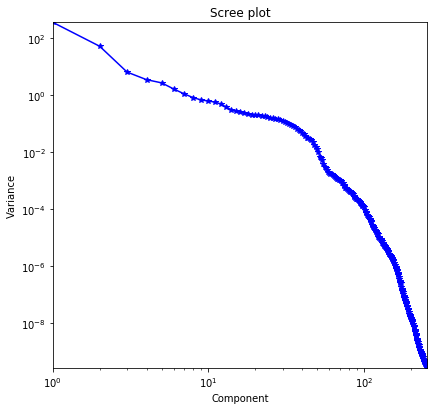

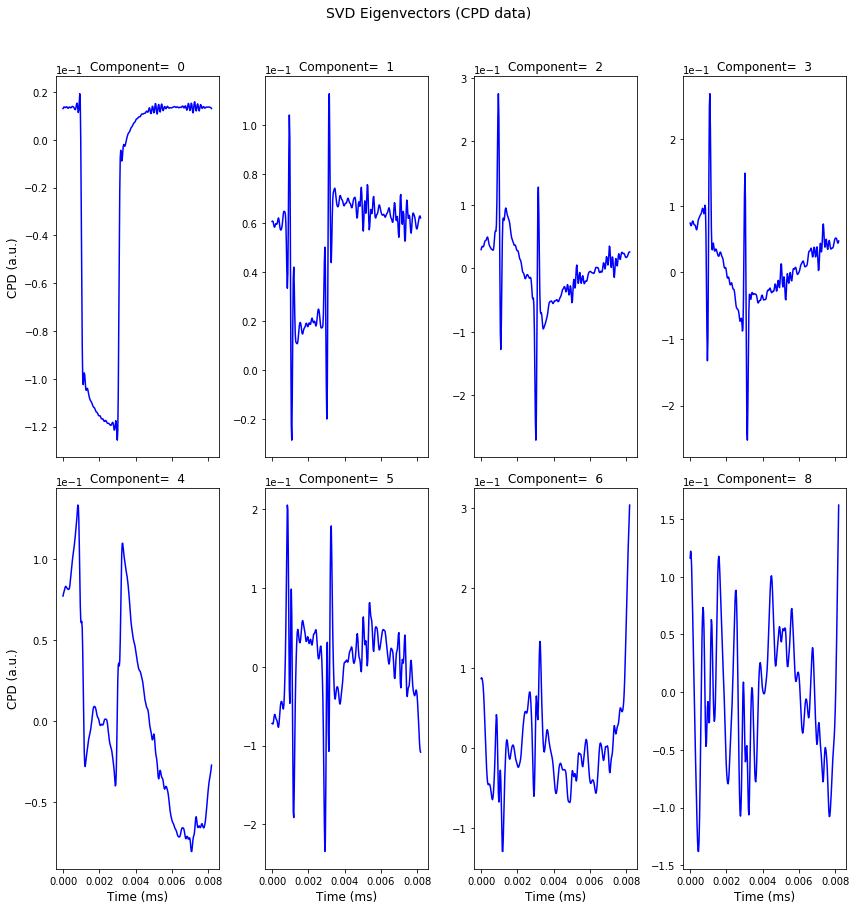

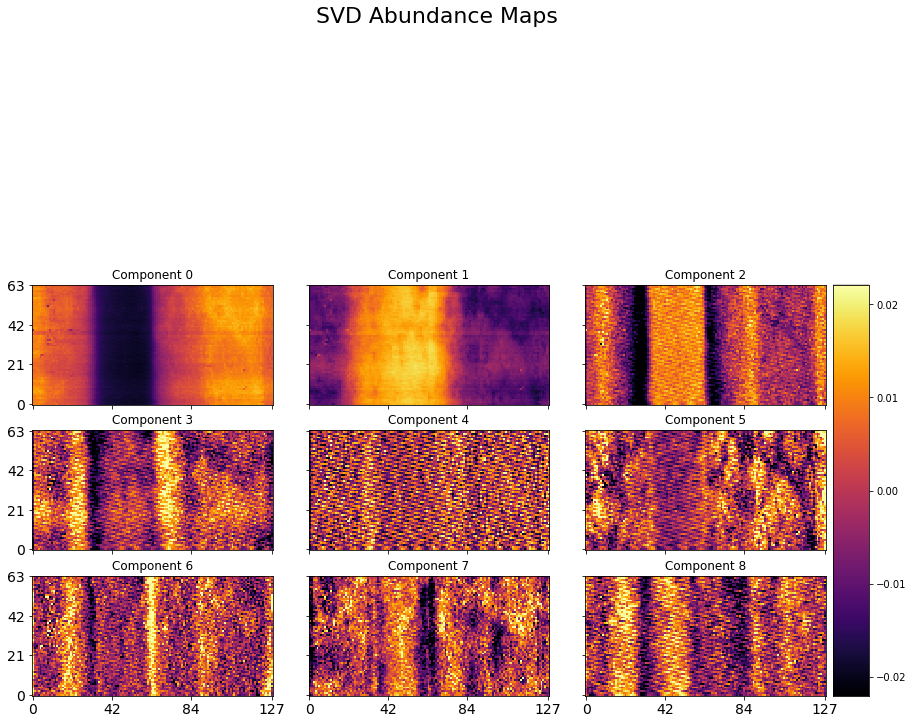

In [83]:

if do_SVD_CPD: #
    ##########################################
    ### DO PCA of CPD results
    ##########################################

    do_svd = px.processing.svd_utils.SVD(h5_CPD, num_components=256)
    h5_svd_group = do_svd.compute(override=True)

    h5_u = h5_svd_group['U']
    h5_v = h5_svd_group['V']
    h5_s = h5_svd_group['S']

    # Since the two spatial dimensions (x, y) have been collapsed to one, we need to reshape the abundance maps:
    abun_maps = np.reshape(h5_u[:,:25], (num_rows, num_cols,-1))

    # Visualize the variance / statistical importance of each component:
    usid.plot_utils.plot_scree(h5_s, title='Scree plot')

    if save_figure == True:
        plt.savefig(output_filepath+'\PCARaw_Scree_CPD.tif', format='tiff')


    # Visualize the eigenvectors:
    first_evecs = h5_v[:9, :]

    fig, axes = usid.plot_utils.plot_curves(time, first_evecs, line_colors=['r'], x_label='Time (ms)',
                                                    y_label='CPD (a.u.)', subtitle_prefix='Component= ', num_plots=8,
                                                    title='SVD Eigenvectors (CPD data)',use_rainbow_plots=False)


    if save_figure == True:
        plt.savefig(output_filepath+'\PCARaw_Eig_CPD.tif', format='tiff')


    # Visualize the abundance maps:
    usid.plot_utils.plot_map_stack(abun_maps, num_comps=9, title='SVD Abundance Maps', reverse_dims=True,
                                 color_bar_mode='single', cmap='inferno', title_yoffset=0.95)


    if save_figure == True:
    #     fig.savefig(output_filepath+'\PCARaw_Loading.eps', format='eps')
    #     fig.savefig(output_filepath+'\PCARaw_Loading.tif', format='tiff')
        plt.savefig(output_filepath+'\PCARaw_Loading_CPD.tif', format='tiff')
        #save_figure = False;


# Dont forget....PCA or SVD components are not physical. We should not try to interpret the components in this sense. HOWEVER, the indications of interface effects are promising and merit further probing.

## kMeans Clustering

KMeans clustering is a quick method to determine the types of spectral responses present in the data. It is not a decomposition method, but a basic clustering method. k-means clustering aims to partition n observations into k clusters in which each observation belongs to the cluster with the nearest mean, serving as a prototype of the cluster.  The user inputs the number of clusters (sets) to partition the data into. There is no precise way to pick the right number of clusters, the elbow method (https://en.wikipedia.org/wiki/Elbow_method_(clustering)) can be used as a guide...but caution should be shown.


# DO kMeans on the Efield

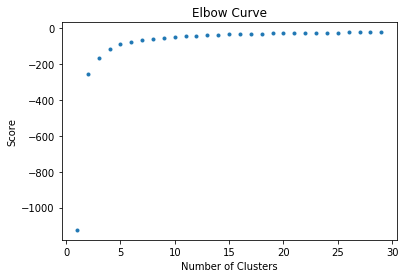

In [91]:
from sklearn.cluster import KMeans
import numpy as np


Nc = range(1, 30)

kmeans = [KMeans(n_clusters=i) for i in Nc]

kmeans

score = [kmeans[i].fit(CPD_off).score(CPD_off) for i in range(len(kmeans))]


plt.plot(Nc,score,'.')

plt.xlabel('Number of Clusters (CPD bias on)')
plt.ylabel('Score')
plt.title('Elbow Curve')
plt.show()



From above it is clear that the score does not change signifcantly by including either 5 or 6 clusters. Its likely that 4 or 4 clusters will optimally describe the data. Note, becuase I have a big jump in the data I have parsed the data into (bias on) and (bias off) and perform Kmeans on each separately.

Performing K-means now
Performing K-means now


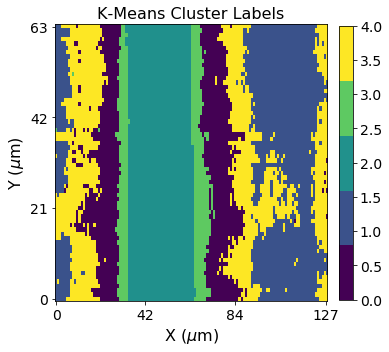

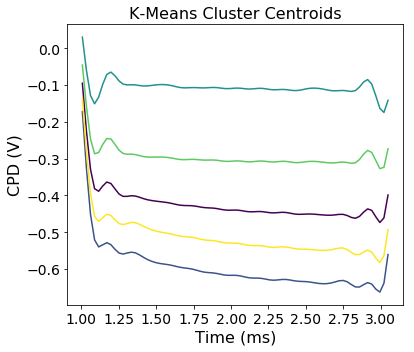

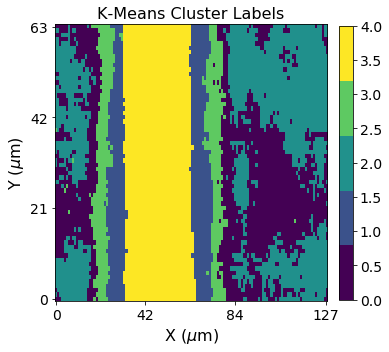

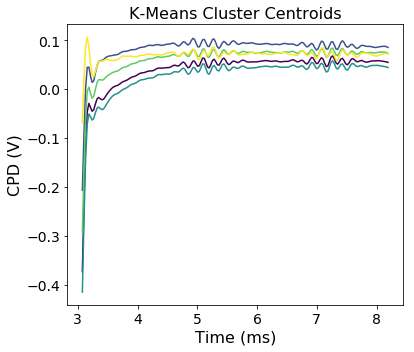

In [93]:
##Do Kmeans on Parsed data
def plot_cluster_results_separately(labels_mat, cluster_centroids, bias_vec, legend_mode=1, **kwargs):
    num_clusters = cluster_centroids.shape[0]
    fig_lab, axis_lab = plt.subplots(figsize=(5.5,5))
    _, _ = px.plot_utils.plot_map(axis_lab, labels_mat, 
                                              clim=[0, num_clusters-1], 
                                              cmap=plt.get_cmap('viridis', num_clusters), 
                                              aspect='auto', show_xy_ticks=True, **kwargs)
    axis_lab.set_xlabel('X ($\mu$m)', fontsize=16)
    axis_lab.set_ylabel('Y ($\mu$m)', fontsize=16)
    axis_lab.set_title('K-Means Cluster Labels', fontsize=16)
    fig_lab.tight_layout()



    # Plot centroids
    fig_width = 5.0
    if legend_mode not in [0, 1]:
        fig_width = 5.85
    fig_centroids, axis_centroids = plt.subplots(figsize=(fig_width, 5))
    colors = [ plt.cm.viridis(x) for x in np.linspace(0, 1, cluster_centroids.shape[0]) ]



    # print('Number of pixels in each cluster:')
    for line_ind in range(cluster_centroids.shape[0]):
        cmap=plt.cm.jet
        line_color=colors[line_ind]
        line_label = 'Cluster ' + str(line_ind)
       # num_of_cluster_members = len(np.where(labels==line_ind)[0])
        # print ("Cluster " + str(line_ind) + ': ' + str(num_of_cluster_members))
        #if num_of_cluster_members > 10:

        axis_centroids.plot(bias_vec, cluster_centroids[line_ind,:],
                            label=line_label, color=line_color) # marker='o', 
    axis_centroids.set_xlabel('Time (ms)', fontsize=16)
    axis_centroids.set_ylabel('CPD (V)', fontsize=16)
    axis_centroids.set_title('K-Means Cluster Centroids', fontsize=16)
    if legend_mode==0:
        axis_centroids.legend(loc='lower right', fontsize=14)
    elif legend_mode==1:
        axis_centroids.legend(loc='upper left', bbox_to_anchor=(1, 1), fontsize=14)
    else:
        sm = px.plot_utils.make_scalar_mappable(0, num_clusters-1, 
                                               cmap=px.plot_utils.discrete_cmap(num_clusters))
       # plt.colorbar(sm)
    px.plot_utils.set_tick_font_size(axis_centroids, 14)
    fig_centroids.tight_layout()

    return fig_lab, fig_centroids

do_Kmeans_split=True
if do_Kmeans_split: #
   
           
 
    ##########################################
    ### DO Kmeans clustering
    ##########################################
    time = np.linspace(0.0, pxl_time, CPD.shape[1])

    ##########################################
    ### Pick aproriate times here for fitting
    ###########################################
    

    
    time_on = time[p_on: p_off]   # last point is sometimes NaN for some reason 
    time_off = time[ p_off:]   # last point is sometimes NaN for some reason 
     # Make CPD on and off, reshape into images by takign averages
    CPD_on = CPD[:, p_on: p_off]
    CPD_off = CPD[:, p_off:]
    
   
    num_clusters = 5


    print('Performing K-means now')
    kmeans = KMeans(n_clusters=num_clusters).fit(CPD_on)
    

   
    h5_kmeans_centroids=np.squeeze(kmeans.cluster_centers_)
    h5_kmeans_labels=kmeans.labels_[:].reshape(num_cols*num_rows,1)
   # h5_kmeans_labels = h5_kmeans_grp['Labels']
   # h5_kmeans_centroids = h5_kmeans_grp['Mean_Response']
    fig_lab, fig_centroids = plot_cluster_results_separately(h5_kmeans_labels[:,:].reshape(num_rows,num_cols), 
                                                            h5_kmeans_centroids[:,:], time_on*1000, legend_mode=2)
    
    if save_figure == True:
        fig_lab.savefig(output_filepath+'\KmeansLabels_CPDbiason.tif', format='tiff')
        fig_centroids.savefig(output_filepath+'\KmeansCentroids_CPDbiason.tif', format='tiff')
        
        
        
    print('Performing K-means now')
    kmeans = KMeans(n_clusters=num_clusters).fit(CPD_off)
    

   
    h5_kmeans_centroids=np.squeeze(kmeans.cluster_centers_)
    h5_kmeans_labels=kmeans.labels_[:].reshape(num_cols*num_rows,1)
    fig_lab, fig_centroids = plot_cluster_results_separately(h5_kmeans_labels[:,:].reshape(num_rows,num_cols), 
                                                            h5_kmeans_centroids[:,:], time_off*1000, legend_mode=2)
    
    if save_figure == True:
        fig_lab.savefig(output_filepath+'\KmeansLabels_CPDbiasoff.tif', format='tiff')
        fig_centroids.savefig(output_filepath+'\KmeansCentroids_CPDbiasoff.tif', format='tiff')